# Modeling Notebook
This notebook contains the transformation of cleaned data into data ready for modelling

## Setup

In [11]:
# Constants
INPUT_FILE = "../3eda/cleaned_jobs.csv"
RANDOM_STATE = 42

In [12]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
import joblib
from tqdm import tqdm
import os

# Load data
print("Loading data...")
df = pd.read_csv(INPUT_FILE)

df.info()

Loading data...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41514 entries, 0 to 41513
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   query                   41514 non-null  object 
 1   country                 41514 non-null  object 
 2   job_description         41514 non-null  object 
 3   location                41508 non-null  object 
 4   job_title               41511 non-null  object 
 5   soft_skills             41514 non-null  object 
 6   hard_skills             41514 non-null  object 
 7   location_flexibility    41514 non-null  object 
 8   contract_type           41514 non-null  object 
 9   education_level         41514 non-null  object 
 10  field_of_study          41514 non-null  object 
 11  seniority               41514 non-null  object 
 12  min_years_experience    41514 non-null  float64
 13  yearly_salary_midpoint  41514 non-null  float64
dtypes: float64(2), object(

## Feature Engineering

### Clustering
An option to deal with the high amounts of possible skills is to cluster them into an `n` set of clusters. This will allow us to control the granularity of the skills.

In [13]:
# Function to convert list strings to actual lists
def parse_list_string(s):
    return [x.strip().strip("'\"") for x in s.strip("[]").split(",") if x.strip()]


# Parse skill columns
df["soft_skills"] = df["soft_skills"].apply(parse_list_string)
df["hard_skills"] = df["hard_skills"].apply(parse_list_string)
df["field_of_study"] = df["field_of_study"].apply(parse_list_string)

In [14]:
# Function to cluster skills
def cluster_skills(skills_list, n_clusters=100, prefix="cluster"):
    skills_text = [" ".join(skill.lower().split("_")) for skill in skills_list]
    vectorizer = TfidfVectorizer(stop_words="english")
    skill_vectors = vectorizer.fit_transform(skills_text)
    kmeans = KMeans(n_clusters=n_clusters, random_state=RANDOM_STATE, n_init=10)
    clusters = kmeans.fit_predict(skill_vectors)
    return {skill: cluster for skill, cluster in zip(skills_list, clusters)}


# Get unique skills and cluster them
N_CLUSTERS = 100
all_soft_skills = set().union(*df["soft_skills"])
all_hard_skills = set().union(*df["hard_skills"])
all_fields = set().union(*df["field_of_study"])

soft_skill_clusters = cluster_skills(list(all_soft_skills), N_CLUSTERS, "soft")
hard_skill_clusters = cluster_skills(list(all_hard_skills), N_CLUSTERS, "hard")
field_clusters = cluster_skills(list(all_fields), N_CLUSTERS, "field")

Essentially what we did for cluster_skills is generate 100 clusters of each respective columns. 

For example:

In [15]:
list(soft_skill_clusters.items())[:10]

[('audit-defense', 1),
 ('openness-to-new-approaches', 1),
 ('technical-investigation', 93),
 ('personnel-supervision', 1),
 ('group-training', 87),
 ('quick-judgment', 1),
 ('risk-evaluation', 8),
 ('trust', 1),
 ('independent-worker', 28),
 ('community-organization', 55)]

Explanation:

The first element `audit-defense` represents the skill. the second element `1` represents the cluster id

Our next step is to create skill features, which can take our current list of skills, and convert them into a feature that shows the count of skills in each vector.

In [16]:
def create_skill_features(row, skill_clusters, n_clusters, prefix):
    cluster_counts = np.zeros(n_clusters)
    for skill in row:
        if skill in skill_clusters:
            cluster_counts[skill_clusters[skill]] += 1
    return {f"{prefix}_cluster_{i}": count for i, count in enumerate(cluster_counts)}


# Create feature matrix
print("Creating features...")
feature_dicts = []
categorical_cols = [
    "country",
    "location_flexibility",
    "contract_type",
    "education_level",
    "seniority",
    "query",
    "job_title",
    "location",
    "min_years_experience",
    "yearly_salary_midpoint",
]

for _, row in tqdm(df.iterrows(), desc="Processing rows"):
    features = {}
    # Add skill features
    features.update(
        create_skill_features(
            row["soft_skills"], soft_skill_clusters, N_CLUSTERS, "soft"
        )
    )
    features.update(
        create_skill_features(
            row["hard_skills"], hard_skill_clusters, N_CLUSTERS, "hard"
        )
    )
    features.update(
        create_skill_features(
            row["field_of_study"], field_clusters, N_CLUSTERS, "field"
        )
    )

    # Add categorical features
    for col in categorical_cols:
        features[col] = row[col] if pd.notna(row[col]) else "unknown"

    feature_dicts.append(features)

# Create final dataframe
df_features = pd.DataFrame(feature_dicts)

Creating features...


Processing rows: 41514it [00:03, 11850.83it/s]


In [17]:
# Create final dataframe
df_features = pd.DataFrame(feature_dicts)

# Train model using PyCaret
from pycaret.regression import *

reg_setup = setup(
    data=df_features,
    target="yearly_salary_midpoint",
    session_id=42,
    normalize=True,
    transformation=True,
)

rf = create_model("rf")

# Display feature importance
feature_importance = pd.DataFrame(
    {
        "Feature": get_config("X_train_transformed").columns,
        "Importance": rf.feature_importances_,
    }
).sort_values("Importance", ascending=False)

print("\nTop 20 Most Important Features:")
print(feature_importance.head(20))

,Description,Value
0,Session id,42
1,Target,yearly_salary_midpoint
2,Target type,Regression
3,Original data shape,"(41514, 310)"
4,Transformed data shape,"(41514, 325)"
5,Transformed train set shape,"(29059, 325)"
6,Transformed test set shape,"(12455, 325)"
7,Numeric features,301
8,Categorical features,8
9,Preprocess,True


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,22407.1293,1579956702.9297,39748.6692,0.5413,0.7816,1.2299
1,21357.2467,1360738120.3321,36888.1840,0.6020,0.8004,1.3332
2,21610.9923,1280990802.1017,35790.9318,0.5877,0.8087,1.2548
3,21889.9945,1485668663.4528,38544.3727,0.5767,0.8046,1.3043
4,23725.4520,2776090082.3552,52688.6144,0.4588,0.7990,1.2480
5,23076.5194,1454091479.2839,38132.5514,0.5542,0.8827,1.5093
6,23103.2742,1648755102.6849,40604.8655,0.5451,0.8483,1.6506
7,21438.0360,1415699785.5631,37625.7862,0.5650,0.7970,1.2239
8,22743.4777,1808491437.3056,42526.3617,0.5044,0.8527,1.6978



Top 20 Most Important Features:
                    Feature  Importance
321               job_title    0.718392
300              country_IN    0.162527
322                location    0.044188
140         hard_cluster_40    0.009608
320                   query    0.005893
316        seniority_senior    0.003758
136         hard_cluster_36    0.002740
227        field_cluster_27    0.002650
323    min_years_experience    0.002543
317     seniority_mid-level    0.001559
93          soft_cluster_93    0.001251
319        seniority_junior    0.001093
211        field_cluster_11    0.000977
1            soft_cluster_1    0.000965
184         hard_cluster_84    0.000827
282        field_cluster_82    0.000782
9            soft_cluster_9    0.000762
287        field_cluster_87    0.000754
308  contract_type_contract    0.000743
171         hard_cluster_71    0.000740


The results are quite promising, with a R^2 of 0.54, meaning a good fit to our data.

In [19]:
# Train separate models for each country
from pycaret.regression import *
import warnings
warnings.filterwarnings('ignore')

countries = ['US', 'IN', 'SG']
models = {}
feature_importances = {}

print("\nTraining separate models for each country:")
print("-" * 50)

for country in countries:
    print(f"\nTraining model for {country}:")
    
    # Filter data for current country
    country_data = df_features[df_features['country'] == country].copy()
    print(f"Number of samples for {country}: {len(country_data)}")
    
    # Setup PyCaret environment for this country
    reg_setup = setup(
        data=country_data,
        target="yearly_salary_midpoint",
        session_id=42,
        normalize=True,
        transformation=True,
        verbose=False
    )
    
    # Train RF model
    rf = create_model("rf", verbose=False)
    
    # Store model and performance
    models[country] = rf
    
    # Get and store feature importance
    feature_importance = pd.DataFrame({
        "Feature": get_config("X_train_transformed").columns,
        "Importance": rf.feature_importances_
    }).sort_values("Importance", ascending=False)
    
    feature_importances[country] = feature_importance
    
    # Print performance metrics
    print(f"\nPerformance metrics for {country}:")
    print(f"R2 Score: {pull()['R2'].values[0]:.3f}")
    print(f"RMSE: {pull()['RMSE'].values[0]:.3f}")
    print(f"MAE: {pull()['MAE'].values[0]:.3f}")
    
    # Print top 10 important features
    print(f"\nTop 10 Most Important Features for {country}:")
    print(feature_importance.head(10))
    print("-" * 50)

# Compare feature importance across countries
print("\nComparison of Top 5 Features Across Countries:")
for country in countries:
    print(f"\n{country} Top 5 Features:")
    print(feature_importances[country].head())


Training separate models for each country:
--------------------------------------------------

Training model for US:
Number of samples for US: 18949

Performance metrics for US:
R2 Score: 0.430
RMSE: 44213.303
MAE: 26105.340

Top 10 Most Important Features for US:
                  Feature  Importance
318                 query    0.349420
320              location    0.217822
316      seniority_senior    0.056810
321  min_years_experience    0.022607
136       hard_cluster_36    0.015747
140       hard_cluster_40    0.015689
174       hard_cluster_74    0.010439
124       hard_cluster_24    0.010008
1          soft_cluster_1    0.008857
93        soft_cluster_93    0.008605
--------------------------------------------------

Training model for IN:
Number of samples for IN: 14259

Performance metrics for IN:
R2 Score: 0.103
RMSE: 6778.109
MAE: 3569.358

Top 10 Most Important Features for IN:
                  Feature  Importance
319             job_title    0.791187
321  min_years_exp

It seems like the model did worse on country-specific data.

## Word2Vec
Let's try generating features using Word2Vec instead of clustering

In [20]:
# Train Word2Vec models
from gensim.models import Word2Vec

# Prepare text for Word2Vec
def prepare_text(skill):
    return skill.lower().replace('_', ' ').split()

# Train separate Word2Vec models for each skill type
VECTOR_SIZE = 100
W2V_WINDOW = 5
MIN_COUNT = 1

print("Training Word2Vec models...")

# Train models
soft_model = Word2Vec(
    sentences=[prepare_text(skill) for skills in df['soft_skills'] for skill in skills],
    vector_size=VECTOR_SIZE,
    window=W2V_WINDOW,
    min_count=MIN_COUNT,
    workers=4
)

hard_model = Word2Vec(
    sentences=[prepare_text(skill) for skills in df['hard_skills'] for skill in skills],
    vector_size=VECTOR_SIZE,
    window=W2V_WINDOW,
    min_count=MIN_COUNT,
    workers=4
)

field_model = Word2Vec(
    sentences=[prepare_text(skill) for skills in df['field_of_study'] for skill in skills],
    vector_size=VECTOR_SIZE,
    window=W2V_WINDOW,
    min_count=MIN_COUNT,
    workers=4
)

def get_skill_vector(skill, model):
    """Get vector for a skill, handling multi-word skills"""
    words = prepare_text(skill)
    vectors = []
    for word in words:
        try:
            vectors.append(model.wv[word])
        except KeyError:
            continue
    return np.mean(vectors, axis=0) if vectors else np.zeros(VECTOR_SIZE)

def create_skill_features(skills, model, prefix):
    """Create averaged vector features for a list of skills"""
    if not skills:
        return {f"{prefix}_vec_{i}": 0 for i in range(VECTOR_SIZE)}
    
    vectors = []
    for skill in skills:
        skill_vector = get_skill_vector(skill, model)
        if not np.all(skill_vector == 0):
            vectors.append(skill_vector)
    
    if not vectors:
        avg_vector = np.zeros(VECTOR_SIZE)
    else:
        avg_vector = np.mean(vectors, axis=0)
    
    return {f"{prefix}_vec_{i}": val for i, val in enumerate(avg_vector)}

# Create feature matrix
print("Creating features...")
feature_dicts = []
categorical_cols = [
    "country",
    "location_flexibility",
    "contract_type",
    "education_level",
    "seniority",
    "query",
    "job_title",
    "location",
    "min_years_experience",
    "yearly_salary_midpoint",
]

for _, row in tqdm(df.iterrows(), desc="Processing rows"):
    features = {}
    
    # Add Word2Vec features
    features.update(create_skill_features(row["soft_skills"], soft_model, "soft"))
    features.update(create_skill_features(row["hard_skills"], hard_model, "hard"))
    features.update(create_skill_features(row["field_of_study"], field_model, "field"))

    # Add categorical features
    for col in categorical_cols:
        features[col] = row[col] if pd.notna(row[col]) else "unknown"

    feature_dicts.append(features)

Training Word2Vec models...
Creating features...


Processing rows: 41514it [00:09, 4437.72it/s]


In [21]:
# Create final dataframe
df_features = pd.DataFrame(feature_dicts)

# Train model using PyCaret
from pycaret.regression import *

reg_setup = setup(
    data=df_features,
    target="yearly_salary_midpoint",
    session_id=42,
    normalize=True,
    transformation=True,
)

rf = create_model("rf")

# Display feature importance
feature_importance = pd.DataFrame(
    {
        "Feature": get_config("X_train_transformed").columns,
        "Importance": rf.feature_importances_,
    }
).sort_values("Importance", ascending=False)

print("\nTop 20 Most Important Features:")
print(feature_importance.head(20))

,Description,Value
0,Session id,42
1,Target,yearly_salary_midpoint
2,Target type,Regression
3,Original data shape,"(41514, 310)"
4,Transformed data shape,"(41514, 325)"
5,Transformed train set shape,"(29059, 325)"
6,Transformed test set shape,"(12455, 325)"
7,Numeric features,301
8,Categorical features,8
9,Preprocess,True


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,22658.7226,1619613776.2619,40244.4254,0.5298,0.7683,1.1632
1,21888.5790,1410479453.3251,37556.3504,0.5874,0.7783,1.2179
2,21787.3699,1306277206.7252,36142.4571,0.5796,0.7869,1.1305
3,22251.4588,1507128847.9045,38821.7574,0.5706,0.7973,1.2487
4,24421.8353,2942607518.7127,54245.8065,0.4263,0.7903,1.1891
5,23153.0748,1496726284.6126,38687.5469,0.5411,0.8580,1.3733
6,23209.1444,1642646675.1287,40529.5778,0.5468,0.8071,1.3868
7,21594.7261,1433823653.9850,37865.8640,0.5595,0.7761,1.1441
8,22756.6748,1832353660.5257,42806.0003,0.4979,0.8294,1.5186



Top 20 Most Important Features:
                 Feature  Importance
321            job_title    0.702558
300           country_IN    0.162384
322             location    0.038297
47           soft_vec_47    0.004234
316     seniority_senior    0.003763
29           soft_vec_29    0.003128
320                query    0.002853
40           soft_vec_40    0.002850
39           soft_vec_39    0.001705
317  seniority_mid-level    0.001598
71           soft_vec_71    0.001184
16           soft_vec_16    0.001086
298         field_vec_98    0.000975
69           soft_vec_69    0.000958
102           hard_vec_2    0.000952
24           soft_vec_24    0.000842
54           soft_vec_54    0.000742
162          hard_vec_62    0.000714
88           soft_vec_88    0.000699
55           soft_vec_55    0.000699


The Word2Vec approach was unsuccessful. However, this may not be suprising as all we did was average the vectors generated by the skills and field of study. Word2Vec approach works better on large corpus of text, and the clustering approach is not only accurate but also interpretable and explanable. 

Thus, it would be a great idea to combine clustering with Word2Vec. To do this, clustering will be applied on the skills, and Word2Vec will be applied on the job_description

In [26]:
# Constants
INPUT_FILE = "../3eda/cleaned_jobs.csv"
RANDOM_STATE = 42

import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm import tqdm
from gensim.models import Word2Vec
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import re

# Download required NLTK data
nltk.download('punkt')
nltk.download('stopwords')

# Load data
print("Loading data...")
df = pd.read_csv(INPUT_FILE)

# Function to convert list strings to actual lists
def parse_list_string(s):
    return [x.strip().strip("'\"") for x in s.strip("[]").split(",") if x.strip()]

# Parse skill columns
df["soft_skills"] = df["soft_skills"].apply(parse_list_string)
df["hard_skills"] = df["hard_skills"].apply(parse_list_string)
df["field_of_study"] = df["field_of_study"].apply(parse_list_string)

# Function to cluster skills
def cluster_skills(skills_list, n_clusters=100, prefix="cluster"):
    skills_text = [" ".join(skill.lower().split("_")) for skill in skills_list]
    vectorizer = TfidfVectorizer(stop_words="english")
    skill_vectors = vectorizer.fit_transform(skills_text)
    kmeans = KMeans(n_clusters=n_clusters, random_state=RANDOM_STATE, n_init=10)
    clusters = kmeans.fit_predict(skill_vectors)
    return {skill: cluster for skill, cluster in zip(skills_list, clusters)}

# Get unique skills and cluster them
N_CLUSTERS = 100
all_soft_skills = set().union(*df["soft_skills"])
all_hard_skills = set().union(*df["hard_skills"])
all_fields = set().union(*df["field_of_study"])

print("Clustering skills...")
soft_skill_clusters = cluster_skills(list(all_soft_skills), N_CLUSTERS, "soft")
hard_skill_clusters = cluster_skills(list(all_hard_skills), N_CLUSTERS, "hard")
field_clusters = cluster_skills(list(all_fields), N_CLUSTERS, "field")

def create_cluster_features(row, skill_clusters, n_clusters, prefix):
    cluster_counts = np.zeros(n_clusters)
    for skill in row:
        if skill in skill_clusters:
            cluster_counts[skill_clusters[skill]] += 1
    return {f"{prefix}_cluster_{i}": count for i, count in enumerate(cluster_counts)}

# Text preprocessing for Word2Vec
def preprocess_text(text):
    if pd.isna(text):
        return []
    # Convert to lowercase
    text = text.lower()
    # Remove special characters and digits
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)
    # Tokenize
    tokens = word_tokenize(text)
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    return tokens

# Prepare sentences for Word2Vec
print("Preparing text data for Word2Vec...")
sentences = []
for desc in tqdm(df['job_description'], desc="Processing job descriptions"):
    tokens = preprocess_text(desc)
    if tokens:
        sentences.append(tokens)

# Train Word2Vec model on job descriptions
print("Training Word2Vec model...")
VECTOR_SIZE = 300
W2V_WINDOW = 10
MIN_COUNT = 5

desc_model = Word2Vec(
    sentences=sentences,
    vector_size=VECTOR_SIZE,
    window=W2V_WINDOW,
    min_count=MIN_COUNT,
    workers=4,
    sg=1
)

# Preprocess corpus once for efficiency
def preprocess_corpus_once(descriptions):
    print("Preprocessing corpus...")
    word_doc_freq = {}
    total_docs = len(descriptions)
    
    for desc in tqdm(descriptions, desc="Calculating document frequencies"):
        tokens = set(preprocess_text(desc))
        for token in tokens:
            word_doc_freq[token] = word_doc_freq.get(token, 0) + 1
    
    word_idf = {word: np.log(total_docs / (1 + freq)) 
                for word, freq in word_doc_freq.items()}
    
    return word_idf

# Calculate IDF scores once
word_idf = preprocess_corpus_once(df['job_description'])

def get_text_vector(text, model, word_idf):
    """Get weighted vector for text"""
    if pd.isna(text):
        return np.zeros(VECTOR_SIZE)
    
    words = preprocess_text(text)
    word_counts = {}
    vectors = []
    weights = []
    
    for word in words:
        word_counts[word] = word_counts.get(word, 0) + 1
    
    for word, count in word_counts.items():
        try:
            vectors.append(model.wv[word])
            weight = count * word_idf.get(word, 0)
            weights.append(weight)
        except KeyError:
            continue
    
    if not vectors:
        return np.zeros(VECTOR_SIZE)
    
    return np.average(vectors, weights=weights, axis=0)

# Create feature matrix
print("Creating features...")
feature_dicts = []
categorical_cols = [
    "country",
    "location_flexibility",
    "contract_type",
    "education_level",
    "seniority",
    "query",
    "job_title",
    "location",
    "min_years_experience",
    "yearly_salary_midpoint",
]

for _, row in tqdm(df.iterrows(), desc="Processing rows"):
    features = {}
    
    # Add clustering features for skills
    features.update(create_cluster_features(row["soft_skills"], soft_skill_clusters, N_CLUSTERS, "soft"))
    features.update(create_cluster_features(row["hard_skills"], hard_skill_clusters, N_CLUSTERS, "hard"))
    features.update(create_cluster_features(row["field_of_study"], field_clusters, N_CLUSTERS, "field"))
    
    # Add Word2Vec features for job description
    desc_vector = get_text_vector(row['job_description'], desc_model, word_idf)
    features.update({f"desc_vec_{i}": val for i, val in enumerate(desc_vector)})
    
    # Add skill counts
    features['soft_skill_count'] = len(row['soft_skills'])
    features['hard_skill_count'] = len(row['hard_skills'])
    features['field_count'] = len(row['field_of_study'])
    
    # Add categorical features
    for col in categorical_cols:
        if col != 'job_description':  # Skip job_description as we're using Word2Vec for it
            features[col] = row[col] if pd.notna(row[col]) else "unknown"

    feature_dicts.append(features)

# Create final dataframe
df_features = pd.DataFrame(feature_dicts)

# Train model using PyCaret
from pycaret.regression import *

reg_setup = setup(
    data=df_features,
    target="yearly_salary_midpoint",
    session_id=42,
    normalize=True,
    transformation=True,
)

rf = create_model("rf")

# Display feature importance
feature_importance = pd.DataFrame(
    {
        "Feature": get_config("X_train_transformed").columns,
        "Importance": rf.feature_importances_,
    }
).sort_values("Importance", ascending=False)

print("\nTop 20 Most Important Features:")
print(feature_importance.head(20))

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/siewweiheng/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/siewweiheng/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Loading data...
Clustering skills...
Preparing text data for Word2Vec...


Processing job descriptions: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41514/41514 [01:51<00:00, 373.85it/s]


Training Word2Vec model...
Preprocessing corpus...


Calculating document frequencies: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41514/41514 [01:41<00:00, 409.57it/s]


Creating features...


Processing rows: 41514it [01:38, 422.54it/s]


,Description,Value
0,Session id,42
1,Target,yearly_salary_midpoint
2,Target type,Regression
3,Original data shape,"(41514, 613)"
4,Transformed data shape,"(41514, 628)"
5,Transformed train set shape,"(29059, 628)"
6,Transformed test set shape,"(12455, 628)"
7,Numeric features,604
8,Categorical features,8
9,Preprocess,True


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,22353.1112,1607006142.1494,40087.4811,0.5334,0.7587,1.1263
1,21347.1796,1389953875.8265,37282.0852,0.5934,0.7641,1.1541
2,21477.9880,1280591372.2562,35785.3514,0.5878,0.7824,1.1355
3,22051.0715,1533353915.7008,39158.0632,0.5631,0.7876,1.2153
4,23957.2410,2920209254.1696,54038.9605,0.4307,0.7638,1.1063
5,22649.4470,1445812116.0627,38023.8362,0.5567,0.8459,1.3332
6,22920.4095,1637116129.4030,40461.2917,0.5483,0.8042,1.3959
7,21141.7940,1411961473.2266,37576.0758,0.5662,0.7577,1.0810
8,22536.8537,1832096318.2828,42802.9943,0.4980,0.8163,1.5017



Top 20 Most Important Features:
                  Feature  Importance
624             job_title    0.707393
603            country_IN    0.162419
625              location    0.036933
619      seniority_senior    0.002460
307            desc_vec_7    0.001975
140       hard_cluster_40    0.001905
623                 query    0.001790
597          desc_vec_297    0.001419
227      field_cluster_27    0.001394
540          desc_vec_240    0.001392
620   seniority_mid-level    0.001125
510          desc_vec_210    0.000849
626  min_years_experience    0.000837
622      seniority_junior    0.000751
595          desc_vec_295    0.000743
569          desc_vec_269    0.000681
457          desc_vec_157    0.000677
523          desc_vec_223    0.000653
379           desc_vec_79    0.000650
407          desc_vec_107    0.000632


## Deep learning benchmark

In [1]:
### import pandas as pd
import numpy as np
import pandas as pd
from transformers import DistilBertTokenizer, DistilBertModel
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import warnings
import joblib
import torch

# Print MPS availability info
print(f"MPS available: {torch.backends.mps.is_available()}")
print(f"MPS built: {torch.backends.mps.is_built()}")

warnings.filterwarnings("ignore")

# Constants
INPUT_FILE = "../3eda/cleaned_jobs.csv"
RANDOM_STATE = 42
MAX_LEN = 512
BATCH_SIZE = 8
EPOCHS = 5
LEARNING_RATE = 2e-5
# Check for MPS availability
if torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
elif torch.cuda.is_available():
    DEVICE = torch.device("cuda")
else:
    DEVICE = torch.device("cpu")

print(f"Using device: {DEVICE}")



# Load data
print("Loading data...")
df = pd.read_csv(INPUT_FILE)

# Prepare text data by combining relevant fields
def prepare_text_input(row):
    text = f"Job Title: {row['job_title']} "
    text += f"Query: {row['query']} "
    text += f"Description: {row['job_description']} "
    text += f"Location: {row['location']} "
    text += f"Country: {row['country']} "
    text += f"Contract: {row['contract_type']} "
    text += f"Education: {row['education_level']} "
    text += f"Seniority: {row['seniority']} "
    text += f"Experience: {row['min_years_experience']} years "
    return text

# Create combined text inputs
df['text_input'] = df.apply(prepare_text_input, axis=1)

# Prepare target variable
y = df['yearly_salary_midpoint'].values
scaler = StandardScaler()
y_scaled = scaler.fit_transform(y.reshape(-1, 1)).flatten()
joblib.dump(scaler, 'salary_scaler.joblib')

# Split data
X_train, X_val, y_train, y_val = train_test_split(
    df['text_input'].values, 
    y_scaled,
    test_size=0.2,
    random_state=RANDOM_STATE
)

# Create Dataset class
class JobDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.float)
        }

# Create model class
class SalaryPredictor(nn.Module):
    def __init__(self, n_hidden=768):
        super().__init__()
        self.bert = DistilBertModel.from_pretrained('distilbert-base-uncased')
        self.drop = nn.Dropout(p=0.2)
        self.fc = nn.Linear(768, n_hidden)  # 768 is DistilBERT's hidden size
        self.relu = nn.ReLU()
        self.out = nn.Linear(n_hidden, 1)
        
    def forward(self, input_ids, attention_mask):
        bert_output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        hidden_state = bert_output[0]  # (bs, seq_len, dim)
        pooled_output = hidden_state[:, 0]  # (bs, dim)
        output = self.drop(pooled_output)
        output = self.fc(output)
        output = self.relu(output)
        output = self.out(output)
        return output

# Training function
def train_epoch(model, data_loader, optimizer, device):
    model.train()
    losses = []
    
    for batch in tqdm(data_loader, desc="Training"):
        optimizer.zero_grad()
        
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        
        loss = nn.MSELoss()(outputs.squeeze(), labels)
        losses.append(loss.item())
        
        loss.backward()
        optimizer.step()
    
    return np.mean(losses)

# Evaluation function
def evaluate(model, data_loader, device):
    model.eval()
    losses = []
    predictions = []
    actual = []
    
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            
            loss = nn.MSELoss()(outputs.squeeze(), labels)
            losses.append(loss.item())
            
            predictions.extend(outputs.squeeze().cpu().numpy())
            actual.extend(labels.cpu().numpy())
    
    return np.mean(losses), predictions, actual

# Initialize tokenizer and create datasets
print("Preparing datasets...")
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

train_dataset = JobDataset(X_train, y_train, tokenizer, MAX_LEN)
val_dataset = JobDataset(X_val, y_val, tokenizer, MAX_LEN)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

# Initialize model and optimizer
print("Initializing model...")
model = SalaryPredictor()
model = model.to(DEVICE)
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)

MPS available: True
MPS built: True
Using device: mps
Loading data...
Preparing datasets...
Initializing model...


In [ ]:
# Training loop
print("Starting training...")
best_val_loss = float('inf')
for epoch in range(EPOCHS):
    print(f'\nEpoch {epoch + 1}/{EPOCHS}')
    
    train_loss = train_epoch(model, train_loader, optimizer, DEVICE)
    val_loss, predictions, actual = evaluate(model, val_loader, DEVICE)
    
    # Convert predictions back to original scale
    predictions_unscaled = scaler.inverse_transform(np.array(predictions).reshape(-1, 1)).flatten()
    actual_unscaled = scaler.inverse_transform(np.array(actual).reshape(-1, 1)).flatten()
    
    # Calculate metrics
    mse = np.mean((predictions_unscaled - actual_unscaled) ** 2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(predictions_unscaled - actual_unscaled))
    
    print(f'Train Loss: {train_loss:.4f}')
    print(f'Val Loss: {val_loss:.4f}')
    print(f'RMSE: ${rmse:.2f}')
    print(f'MAE: ${mae:.2f}')
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pt')
        print("Saved best model!")

# Final evaluation
print("\nFinal Evaluation:")
model.load_state_dict(torch.load('best_model.pt'))
val_loss, predictions, actual = evaluate(model, val_loader, DEVICE)

# Convert predictions back to original scale
predictions_unscaled = scaler.inverse_transform(np.array(predictions).reshape(-1, 1)).flatten()
actual_unscaled = scaler.inverse_transform(np.array(actual).reshape(-1, 1)).flatten()

# Calculate final metrics
mse = np.mean((predictions_unscaled - actual_unscaled) ** 2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(predictions_unscaled - actual_unscaled))

print(f'Final RMSE: ${rmse:.2f}')
print(f'Final MAE: ${mae:.2f}')

# Save some example predictions
examples = pd.DataFrame({
    'Actual Salary': actual_unscaled[:10],
    'Predicted Salary': predictions_unscaled[:10],
    'Difference': predictions_unscaled[:10] - actual_unscaled[:10]
})
print("\nExample Predictions:")
print(examples)

In [2]:
def load_saved_model(model_path='best_model.pt', device=DEVICE):
    """
    Load a saved model with all its components
    """
    # Initialize the model architecture
    model = SalaryPredictor()
    
    # Load the saved state dictionary
    model.load_state_dict(torch.load(model_path, map_location=device))
    
    # Move model to the specified device
    model = model.to(device)
    
    # Set model to evaluation mode
    model.eval()
    
    return model

In [3]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np


def mean_absolute_percentage_error(y_true, y_pred):
    """Calculate MAPE"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    # Avoid division by zero
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100


def root_mean_squared_log_error(y_true, y_pred):
    """Calculate RMSLE"""
    return np.sqrt(mean_squared_error(np.log1p(y_true), np.log1p(y_pred)))


# Load best model
model = load_saved_model()
model.eval()

scaler = joblib.load("salary_scaler.joblib")
# Evaluate on validation set
_, predictions, actual = evaluate(model, val_loader, DEVICE)

# Unscale predictions and actual values
predictions_unscaled = scaler.inverse_transform(
    np.array(predictions).reshape(-1, 1)
).flatten()
actual_unscaled = scaler.inverse_transform(np.array(actual).reshape(-1, 1)).flatten()

# Calculate all metrics
mae = mean_absolute_error(actual_unscaled, predictions_unscaled)
mse = mean_squared_error(actual_unscaled, predictions_unscaled)
rmse = np.sqrt(mse)
r2 = r2_score(actual_unscaled, predictions_unscaled)
rmsle = root_mean_squared_log_error(actual_unscaled, predictions_unscaled)
mape = mean_absolute_percentage_error(actual_unscaled, predictions_unscaled)

# Create evaluation report
print("\n=== Salary Prediction Model Evaluation Report ===")
print(f"{'Metric':<10} | {'Value':<15} | {'Description'}")
print("-" * 60)
print(f"{'MAE':<10} | {mae:15.2f} | Mean Absolute Error")
print(f"{'MSE':<10} | {mse:15.2f} | Mean Squared Error")
print(f"{'RMSE':<10} | {rmse:15.2f} | Root Mean Squared Error")
print(f"{'R2':<10} | {r2:15.4f} | R-squared Score")
print(f"{'RMSLE':<10} | {rmsle:15.4f} | Root Mean Squared Logarithmic Error")
print(f"{'MAPE':<10} | {mape:15.2f}% | Mean Absolute Percentage Error")
print("\nNote:")
print("- Lower values are better for MAE, MSE, RMSE, RMSLE, and MAPE")
print("- R2 ranges from -∞ to 1, where 1 is perfect prediction")


=== Salary Prediction Model Evaluation Report ===
Metric     | Value           | Description
------------------------------------------------------------
MAE        |        16186.46 | Mean Absolute Error
MSE        |    890300352.00 | Mean Squared Error
RMSE       |        29837.90 | Root Mean Squared Error
R2         |          0.7241 | R-squared Score
RMSLE      |          0.6186 | Root Mean Squared Logarithmic Error
MAPE       |           70.28% | Mean Absolute Percentage Error

Note:
- Lower values are better for MAE, MSE, RMSE, RMSLE, and MAPE
- R2 ranges from -∞ to 1, where 1 is perfect prediction


In [4]:
import pandas as pd
from IPython.display import display

# Create DataFrame for metrics
metrics_data = {
    "Metric": ["MAE", "MSE", "RMSE", "R2", "RMSLE", "MAPE"],
    "Value": [
        f"{mae:,.2f}",
        f"{mse:,.2f}",
        f"{rmse:,.2f}",
        f"{r2:.4f}",
        f"{rmsle:.4f}",
        f"{mape:.2f}%",
    ],
    "Description": [
        "Mean Absolute Error",
        "Mean Squared Error",
        "Root Mean Squared Error",
        "R-squared Score",
        "Root Mean Squared Logarithmic Error",
        "Mean Absolute Percentage Error",
    ],
}

df_metrics = pd.DataFrame(metrics_data)

# Style the DataFrame
styled_df = (
    df_metrics.style.set_properties(**{"text-align": "left"})
    .set_table_styles(
        [
            {
                "selector": "th",
                "props": [
                    ("background-color", "#f0f0f0"),
                    ("font-weight", "bold"),
                    ("text-align", "left"),
                    ("padding", "8px"),
                ],
            },
            {"selector": "td", "props": [("padding", "8px")]},
            {
                "selector": "",
                "props": [
                    ("border", "1px solid #ddd"),
                    ("border-collapse", "collapse"),
                ],
            },
        ]
    )
    .hide(axis="index")
)

print("\n=== Salary Prediction Model Evaluation Report ===\n")
display(styled_df)

print("\nNote:")
print("- Lower values are better for MAE, MSE, RMSE, RMSLE, and MAPE")
print("- R2 ranges from -∞ to 1, where 1 is perfect prediction")


=== Salary Prediction Model Evaluation Report ===



Metric,Value,Description
MAE,"16,186.46",Mean Absolute Error
MSE,"890,300,352.00",Mean Squared Error
RMSE,"29,837.90",Root Mean Squared Error
R2,0.7241,R-squared Score
RMSLE,0.6186,Root Mean Squared Logarithmic Error
MAPE,70.28%,Mean Absolute Percentage Error



Note:
- Lower values are better for MAE, MSE, RMSE, RMSLE, and MAPE
- R2 ranges from -∞ to 1, where 1 is perfect prediction


In [6]:

# Example of loading the model
print("\nLoading saved model...")
loaded_model = load_saved_model('best_model.pt')
scaler = joblib.load("salary_scaler.joblib")
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

print("Model loaded successfully!")


def predict_salary(input_text, model, tokenizer, scaler, device):
    """
    Optimized prediction function for faster inference
    """
    # Ensure model is in eval mode
    model.eval()
    
    # Prepare the input - use shorter max length for prediction
    encoding = tokenizer.encode_plus(
        input_text,
        add_special_tokens=True,
        max_length=512,  # Reduced from 512 for faster prediction
        return_token_type_ids=False,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )
    
    # Move to device
    with torch.no_grad():  # Ensure no gradients are calculated
        input_ids = encoding['input_ids'].to(device)
        attention_mask = encoding['attention_mask'].to(device)
        
        # Get prediction
        output = model(input_ids=input_ids, attention_mask=attention_mask)
        
        # Move output to CPU and convert to numpy
        output = output.cpu()
    
    # Convert prediction back to salary scale
    scaled_pred = output.numpy()
    prediction = scaler.inverse_transform(scaled_pred)[0][0]
    
    return prediction

# Example usage with timing
import time

print("\nMaking prediction...")
sample_input = """Job Title: Senior Data Scientist 
Query: Data Scientist
Description: Looking for an experienced data scientist with Python and ML expertise. Strong background in machine learning, statistical analysis, and deep learning required. Must be proficient in Python, SQL, and data visualization.
Location: San Francisco
Country: USA
Contract: Full-time
Education: Masters
Seniority: Senior 
Experience: 5 years"""

start_time = time.time()
predicted_salary = predict_salary(sample_input,
                                  loaded_model,
                                  tokenizer,
                                  scaler,
                                  DEVICE)
end_time = time.time()

print(f"Prediction time: {end_time - start_time:.2f} seconds")
print(f"Predicted Salary: ${predicted_salary:,.2f}")



Loading saved model...
Model loaded successfully!

Making prediction...
Prediction time: 0.04 seconds
Predicted Salary: $143,196.95


In [20]:
def get_model_size_mb(model):
    """Calculate model size in MB"""
    param_size = 0
    for param in model.parameters():
        param_size += param.nelement() * param.element_size()
    buffer_size = 0
    for buffer in model.buffers():
        buffer_size += buffer.nelement() * buffer.element_size()
    size_mb = (param_size + buffer_size) / 1024**2
    return size_mb


def get_model_stats(model):
    """Get model statistics"""
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total_params, trainable_params


# Get model details
model_size_mb = get_model_size_mb(loaded_model)
total_params, trainable_params = get_model_stats(loaded_model)

# Make prediction with timing
start_time = time.time()
predicted_salary = predict_salary(sample_input, loaded_model, tokenizer, scaler, DEVICE)
end_time = time.time()
inference_time = end_time - start_time

# Print detailed results
print("\n=== Model Details ===")
print(f"Model Size: {model_size_mb:.2f} MB")
print(f"Total Parameters: {total_params:,}")
print(f"Trainable Parameters: {trainable_params:,}")
print(f"Model Architecture: {loaded_model.__class__.__name__}")
print(f"Device: {DEVICE}")

print("\n=== Inference Details ===")
print(f"Inference Time: {inference_time:.3f} seconds")
print(f"Samples per Second: {1/inference_time:.2f}")

print("\n=== Prediction Result ===")
print(f"Predicted Salary: ${predicted_salary:,.2f}")


=== Model Details ===
Model Size: 255.41 MB
Total Parameters: 66,954,241
Trainable Parameters: 66,954,241
Model Architecture: SalaryPredictor
Device: mps

=== Inference Details ===
Inference Time: 0.036 seconds
Samples per Second: 27.57

=== Prediction Result ===
Predicted Salary: $143,196.95


In [14]:
new_input = """Job Title: Machine Learning Engineer
Query: ML Engineer
Description: Building and deploying ML models
Location: New York
Country: USA
Contract: Full-time
Education: Bachelors
Seniority: Mid-level
Experience: 3 years"""

predicted_salary = predict_salary(new_input, loaded_model, tokenizer, scaler, DEVICE)
print(f"Predicted Salary: ${predicted_salary:,.2f} USD/year")

Predicted Salary: $146,980.67USD/year


With an R^2 of 0.72, prediction time of 0.03 seconds, and a predicted salary that makes a lot of sense, the distilBERT model seems like the best option.

In [15]:
print("\nMaking predictions for different countries...")

# Base job description
base_input = """Job Title: Senior Data Scientist 
Query: Data Scientist
Description: Looking for an experienced data scientist with Python and ML expertise. Strong background in machine learning, statistical analysis, and deep learning required. Must be proficient in Python, SQL, and data visualization.
Education: Masters
Contract: Full-time
Seniority: Senior 
Experience: 5 years"""

# Different locations to test
locations = [
    ("San Francisco", "US"),
    ("Bangalore", "IN"),
    ("Singapore", "SG")
]

for city, country in locations:
    print(f"\nPredicting salary for {city}, {country}:")
    
    sample_input = base_input + f"\nLocation: {city}\nCountry: {country}"
    
    start_time = time.time()
    predicted_salary = predict_salary(sample_input, loaded_model, tokenizer, scaler, DEVICE)
    end_time = time.time()
    
    print(f"Prediction time: {end_time - start_time:.2f} seconds")
    print(f"Predicted Salary: ${predicted_salary:,.2f} USD/year")


Making predictions for different countries...

Predicting salary for San Francisco, US:
Prediction time: 0.06 seconds
Predicted Salary: $150,065.17 USD/year

Predicting salary for Bangalore, IN:
Prediction time: 0.02 seconds
Predicted Salary: $7,371.77 USD/year

Predicting salary for Singapore, SG:
Prediction time: 0.02 seconds
Predicted Salary: $72,803.52 USD/year


Comparison to available models:

Searching the term "Salary Prediction models" online, there seem to be no models available to benchmark against my distilBERT model.

https://www.kaggle.com/datasets/mrsimple07/salary-prediction-data
This is a synthetic dataset generated. 

https://github.com/Pranjali1049/Salary_Prediction/blob/main/Salary%20Prediction.ipynb
Models trained with it are able to get 97% R^2 and between 9k-22k RMSE.

https://predictsalary.com/
There is also this web application, and it looks like you need to create an account to make a prediction. To try it out, i did.
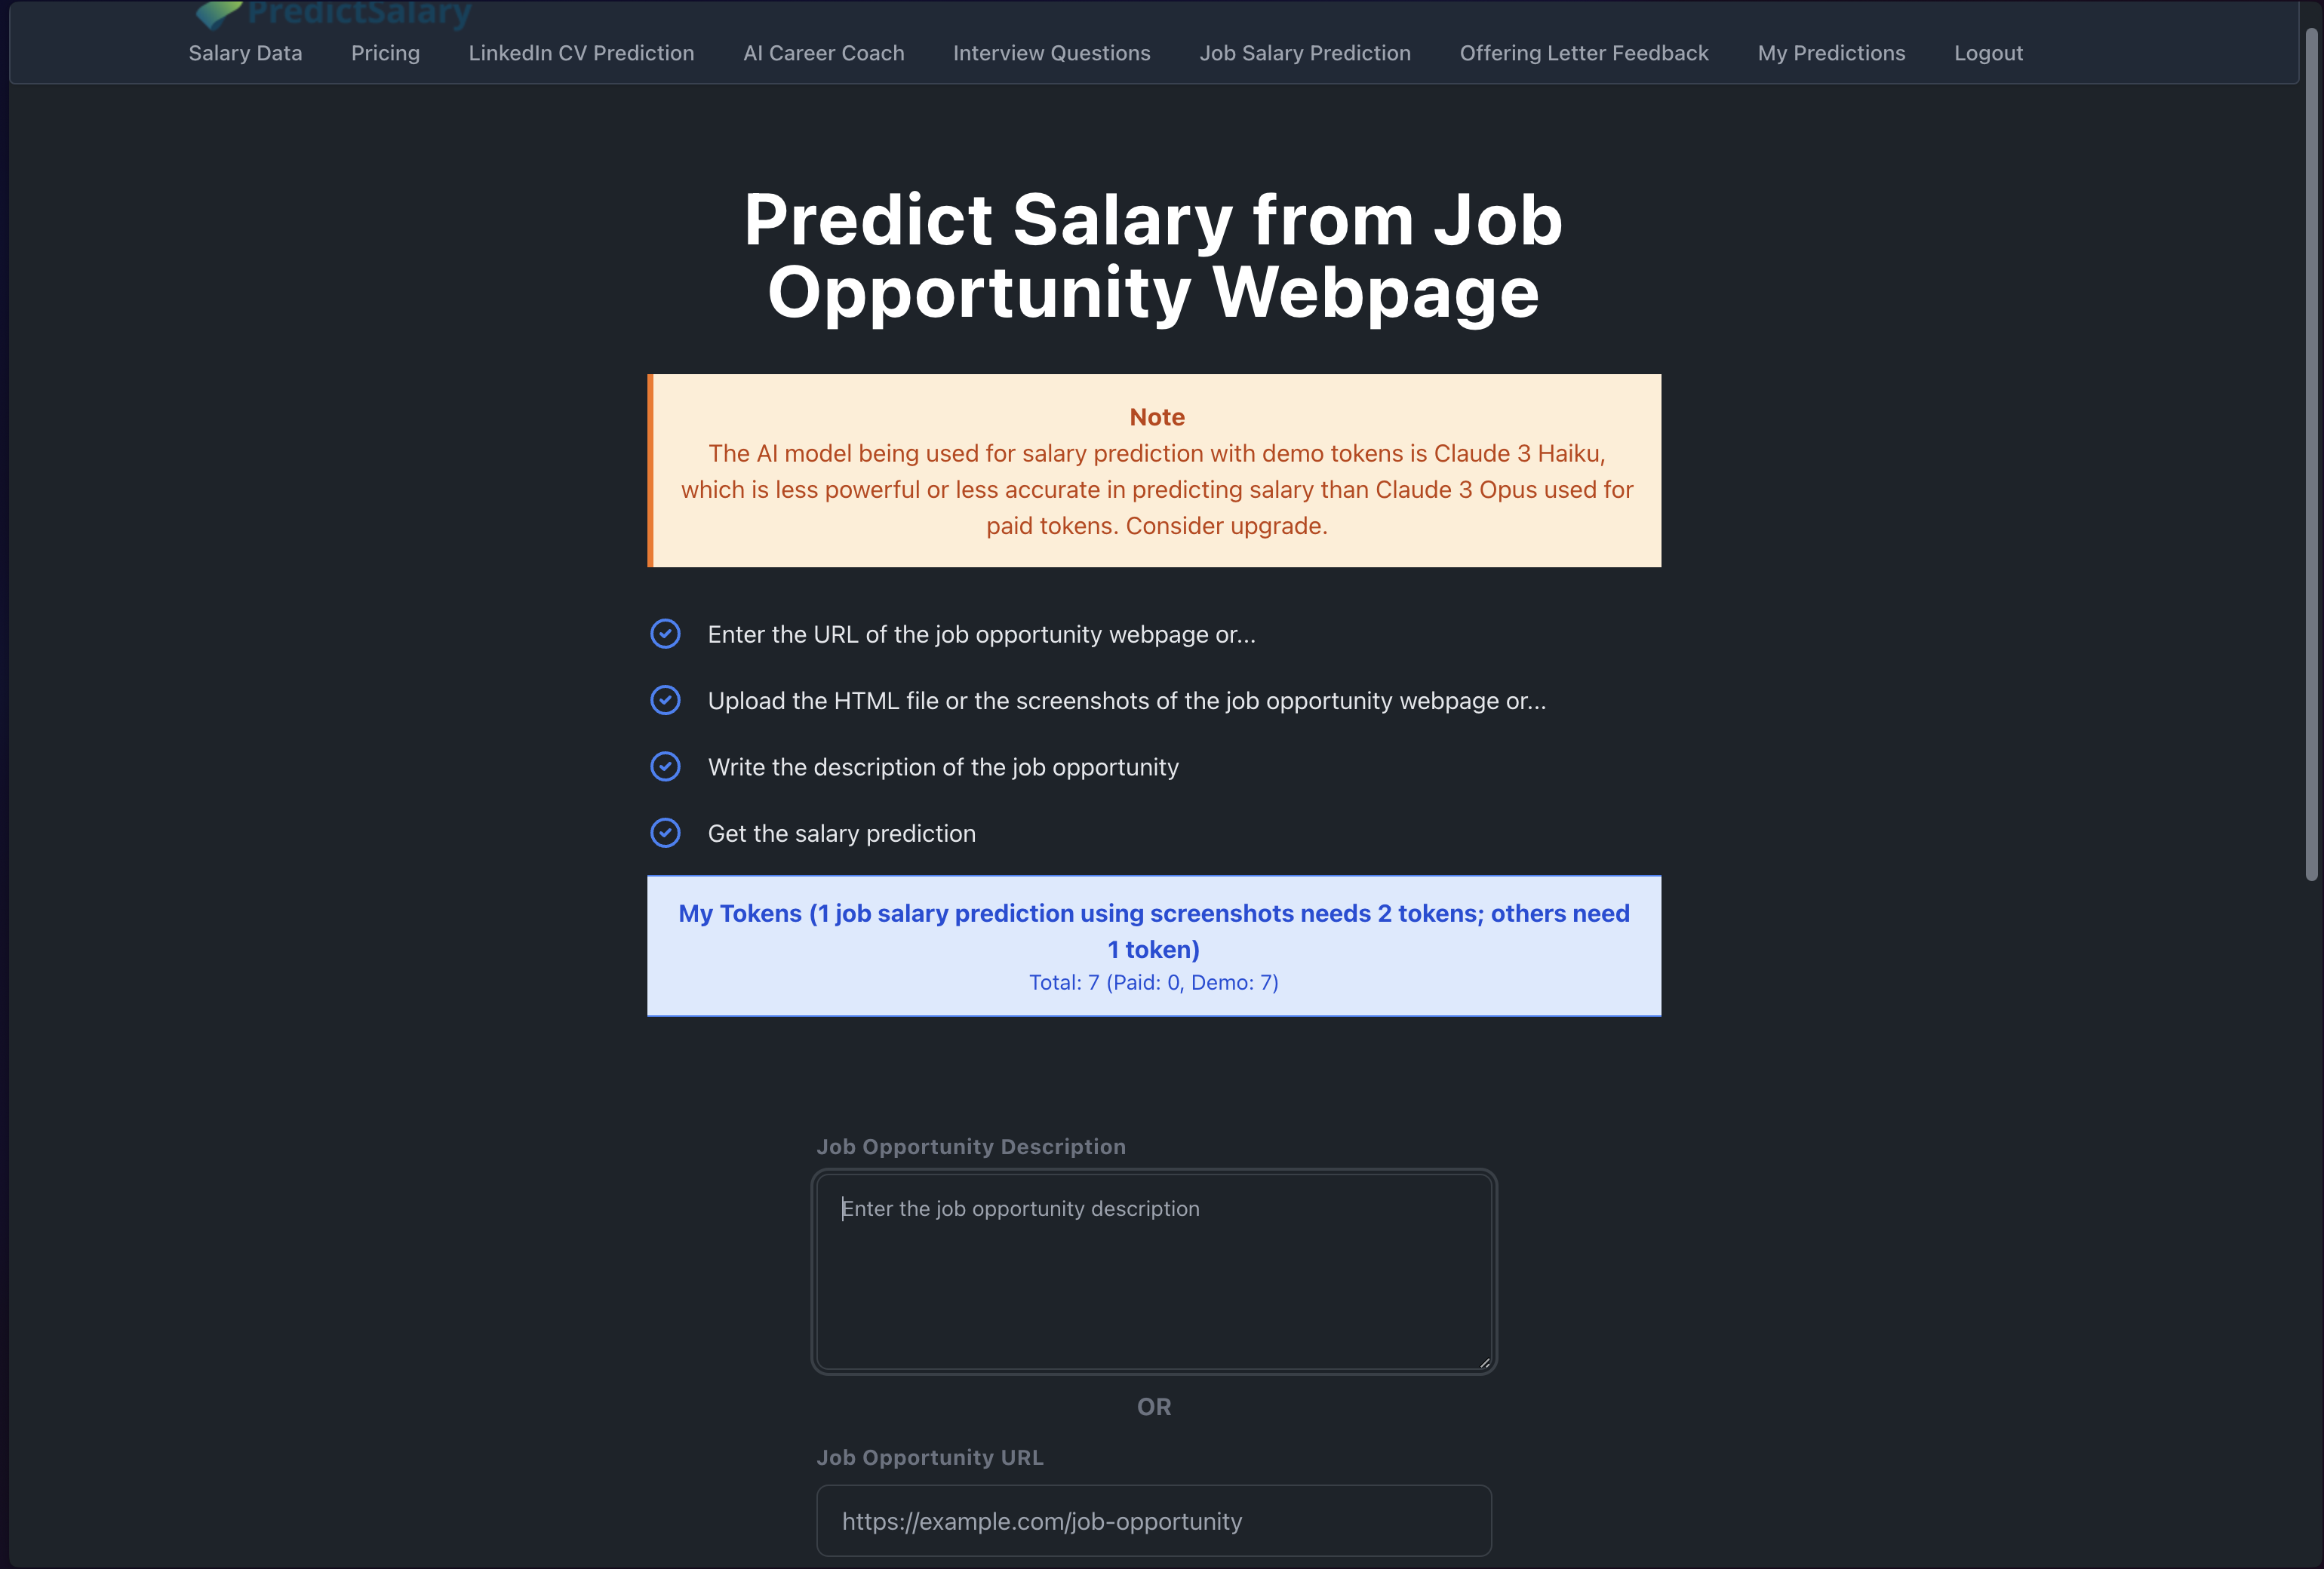

I realized they were just using claude.

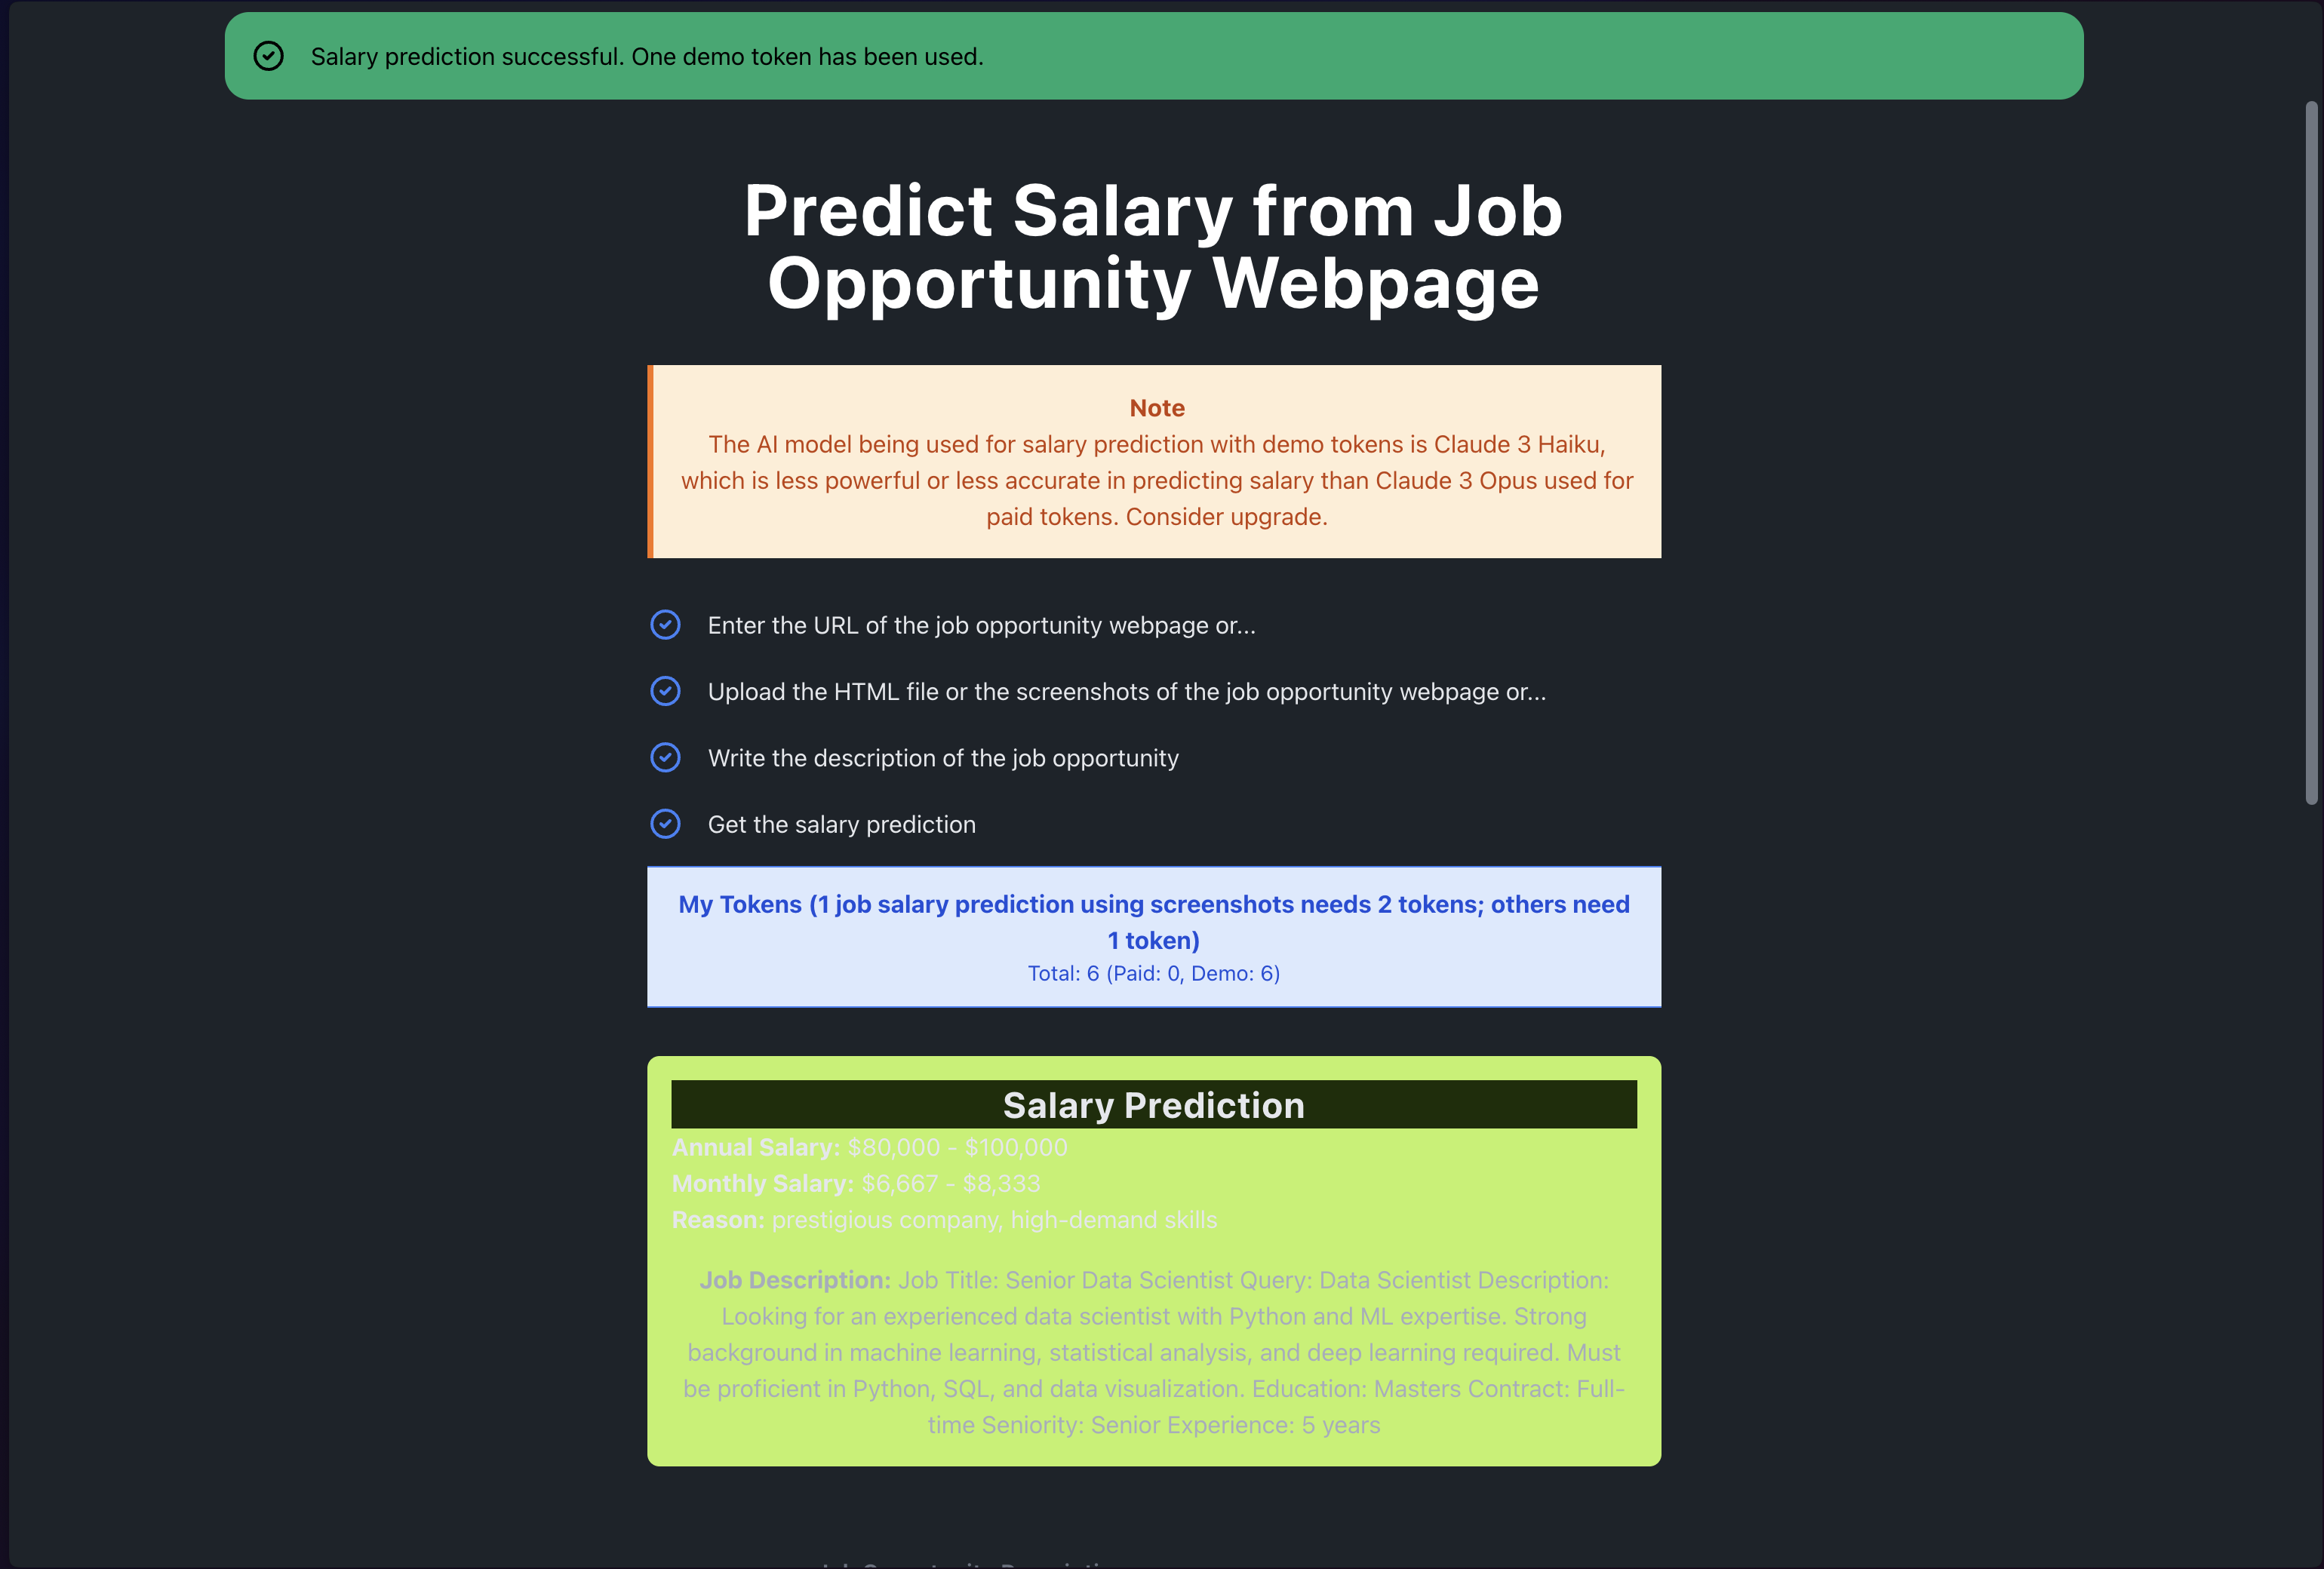

Annual Salary: $80,000 - $100,000

Monthly Salary: $6,667 - $8,333

Reason: prestigious company, high-demand skills

It looks like the salary prediction isn't accurate. And additionally, its not even a trained ML model, its just calling anthropic's claude-haiku model to make an assumed predictions, which is why the values given have a few significant figures.

However, it would be insightful to benchmark our BERT model against Generative AI models and see how they fare against each other. Keeping in mind that the BERT model has several other advantages despite its predictive power:
- Faster to run (0.02-0.06 seconds/prediction)
- Private (Able to be locally hosted)
- Smaller model size (cheaper to host)

Without further ado, let's test our BERT model against 3 popular generative AI providers, which are `OpenAI`, `Anthropic`, and `Google`.

In [1]:
!export OPENAI_API_KEY="your_api_key"
!export ANTHROPIC_API_KEY="your_api_key"
!export GOOGLE_API_KEY="your_api_key"

In [22]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
import openai
import anthropic
import google.generativeai as genai
from sklearn.model_selection import train_test_split
import time
import os
from tqdm import tqdm
import joblib
import matplotlib.pyplot as plt

# Load your API keys
openai.api_key = os.getenv("OPENAI_API_KEY")
claude_api_key = os.getenv("ANTHROPIC_API_KEY")
genai.configure(api_key=os.getenv("GOOGLE_API_KEY"))


def format_prompt(row):
    """Format the input data into a prompt"""
    return f"""Based on the following job details, predict the annual salary in USD:
Job Title: {row['job_title']}
Description: {row['job_description'][:500]}...
Location: {row['location']}
Country: {row['country']}
Contract Type: {row['contract_type']}
Education Level: {row['education_level']}
Seniority: {row['seniority']}
Experience Required: {row['min_years_experience']} years

Please respond with only the numerical salary prediction in USD, without any other text or symbols."""


def get_openai_prediction(prompt):
    """Get prediction from OpenAI GPT-4"""
    try:
        response = openai.ChatCompletion.create(
            model="gpt-4o-mini",
            messages=[{"role": "user", "content": prompt}],
            temperature=0,
        )
        # Extract numerical value from response
        return float(
            response.choices[0]
            .message.content.strip()
            .replace("$", "")
            .replace(",", "")
        )
    except Exception as e:
        print(f"OpenAI Error: {e}")
        return None


def get_claude_prediction(prompt):
    """Get prediction from Anthropic's Claude"""
    try:
        client = anthropic.Client(api_key=claude_api_key)
        response = client.messages.create(
            model="claude-3-5-haiku-latest",
            max_tokens=100,
            temperature=0,
            messages=[{"role": "user", "content": prompt}],
        )
        return float(response.content[0].text.strip().replace("$", "").replace(",", ""))
    except Exception as e:
        print(f"Claude Error: {e}")
        return None


def get_gemini_prediction(prompt):
    """Get prediction from Google's Gemini"""
    try:
        model = genai.GenerativeModel("gemini-2.0-flash")
        response = model.generate_content(prompt)
        return float(response.text.strip().replace("$", "").replace(",", ""))
    except Exception as e:
        print(f"Gemini Error: {e}")
        return None


def evaluate_predictions(actual, predicted):
    """Calculate RMSE and R² scores"""
    # Remove any None values
    valid_indices = [i for i, x in enumerate(predicted) if x is not None]
    actual = [actual[i] for i in valid_indices]
    predicted = [predicted[i] for i in valid_indices]

    rmse = np.sqrt(mean_squared_error(actual, predicted))
    r2 = r2_score(actual, predicted)
    return rmse, r2


def main():
    # Load validation dataset and scaler
    df = pd.read_csv("../3eda/cleaned_jobs.csv")

    # Prepare target variable
    y = df['yearly_salary_midpoint'].values
    
    # Split data using same parameters as BERT model
    X_train, X_val, y_train, y_val = train_test_split(
        df,  # Pass full dataframe to keep all columns
        y,
        test_size=0.2,
        random_state=42  # Same as BERT's RANDOM_STATE
    )
    
    sample = 100
    random_indices = np.random.choice(len(X_val), sample, replace=False)
    val_data = X_val.iloc[random_indices].copy()
    y_val = y_val[random_indices]
    
    print(f"\nUsing {sample} random validation samples")

    
    scaler = joblib.load(
        "salary_scaler.joblib"
    )  # Load the same scaler used in BERT model

    # Store predictions for each model
    predictions = {
        "openai": [],
        "claude": [],
        "gemini": [],
        "bert": [],  # We'll load BERT predictions for comparison
    }

    # Get BERT predictions using the same format as LLMs
    bert_preds = []
    for idx, row in val_data.iterrows():
        text_input = f"Job Title: {row['job_title']} "
        text_input += f"Query: {row['query']} "
        text_input += f"Description: {row['job_description']} "
        text_input += f"Location: {row['location']} "
        text_input += f"Country: {row['country']} "
        text_input += f"Contract: {row['contract_type']} "
        text_input += f"Education: {row['education_level']} "
        text_input += f"Seniority: {row['seniority']} "
        text_input += f"Experience: {row['min_years_experience']} years "

        # Using your existing predict_salary function
        bert_pred = predict_salary(text_input, loaded_model, tokenizer, scaler, DEVICE)
        bert_preds.append(bert_pred)

    predictions["bert"] = bert_preds

    # Get predictions from LLMs for each row
    for idx, row in tqdm(val_data.iterrows(), total=len(val_data)):
        prompt = format_prompt(row)

        # Get predictions from each LLM
        openai_pred = get_openai_prediction(prompt)
        claude_pred = get_claude_prediction(prompt)
        gemini_pred = get_gemini_prediction(prompt)
    
        predictions["openai"].append(openai_pred)
        predictions["claude"].append(claude_pred)
        predictions["gemini"].append(gemini_pred)

    # Get actual salaries
    actual_salaries = y_val

    # Calculate metrics for each model
    results = {}
    print(f"Actual values: {actual_salaries}")
    for model_name, preds in predictions.items():
        # Convert predictions to numpy array and handle None values
        preds = np.array([p if p is not None else np.nan for p in preds])
        valid_mask = ~np.isnan(preds)

        # Use only valid predictions
        valid_preds = preds[valid_mask]
        valid_actual = actual_salaries[valid_mask]

        # Debug prints
        print(f"\nDebug {model_name}:")
        print(f"Predictions: {valid_preds}")
        

        # Calculate metrics
        rmse = np.sqrt(mean_squared_error(valid_actual, valid_preds))
        r2 = r2_score(valid_actual, valid_preds)

        results[model_name] = {
            "RMSE": rmse,
            "R²": r2,
            "Valid Predictions": len(valid_preds),
            "Total Samples": len(actual_salaries),
        }

    # Print results
    print("\nModel Comparison Results:")
    print("------------------------")
    for model_name, metrics in results.items():
        print(f"\n{model_name.upper()}:")
        print(f"RMSE: ${metrics['RMSE']:,.2f}")
        print(f"R²: {metrics['R²']:.4f}")
        print(
            f"Valid Predictions: {metrics['Valid Predictions']}/{metrics['Total Samples']}"
        )

    # Optional: Save results
    results_df = pd.DataFrame(results).T
    results_df.to_csv("model_comparison_results.csv")

    # Optional: Create visualization
    plt.figure(figsize=(10, 6))
    models = list(results.keys())
    r2_scores = [results[model]["R²"] for model in models]

    plt.bar(models, r2_scores)
    plt.title("R² Score Comparison Across Models")
    plt.ylabel("R² Score")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig("model_comparison.png")
    plt.close()


# Run directly in Jupyter notebook
main()


Using 100 random validation samples


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [04:17<00:00,  2.58s/it]

Actual values: [2.220000e+04 1.332000e+04 7.800000e+03 6.216000e+04 1.152000e+03
 1.020000e+04 1.440000e+04 1.728000e+03 6.850000e+04 8.320000e+04
 8.640000e+03 9.900000e+04 1.185000e+05 8.750000e+04 3.600000e+04
 4.320000e+03 3.996000e+04 9.240000e+04 1.440000e+02 9.870000e+04
 1.200000e+05 3.996000e+04 4.800000e+03 4.384640e+04 2.160000e+03
 7.920000e+03 4.200000e+03 2.974800e+04 1.860000e+04 8.998080e+04
 8.880000e+04 7.000000e+04 4.104000e+03 6.216000e+04 9.000000e+04
 3.552000e+04 1.355000e+05 4.800000e+03 1.140000e+05 7.280000e+04
 1.224365e+05 1.875000e+05 2.940000e+04 1.075000e+05 4.662000e+04
 1.206504e+05 2.770560e+04 5.550000e+05 8.375000e+04 3.996000e+04
 1.725000e+05 4.992000e+04 9.000000e+03 1.500000e+05 4.200000e+03
 6.216000e+04 6.000000e+03 8.140000e+03 7.200000e+03 5.328000e+04
 7.440000e+04 1.165900e+05 3.240000e+03 6.450000e+04 3.108000e+04
 1.243200e+05 8.436000e+04 5.772000e+04 7.800000e+03 1.800000e+02
 3.600000e+03 8.450000e+04 7.200000e+03 6.350000e+04 4.800000

Our BERT model shows significantly better performance than just asking chatgpt to predict the salary. This means that our model is not obsoleted by LLMs trained on large corpus of text. Our model is also has a significantly higher speed, smaller size, and can be locally ran.

This makes our model valuable in predicting salary.

## Conclusion
We will use this best_model.pt in our web application

## Extra experimentation

In [8]:
# Train Random Forest with better parameters
print("\nTraining Random Forest model...")
rf_model = RandomForestRegressor(
    n_estimators=200,
    max_depth=15,
    min_samples_split=10,
    min_samples_leaf=4,
    max_features="sqrt",
    bootstrap=True,
    random_state=RANDOM_STATE,
    n_jobs=-1,
)

# Fit and get feature importances
rf_model.fit(X_train, y_train)

# Print feature importances before proceeding
print("\nInitial Feature Importances:")
feature_imp = pd.DataFrame(
    {"feature": feature_names, "importance": rf_model.feature_importances_}
)
feature_imp = feature_imp.sort_values("importance", ascending=False)
print(feature_imp.head(10).to_string(index=False))

# Check for potential data issues
print("\nData Diagnostics:")
print(f"Training set shape: {X_train.shape}")
print(f"Target value range: {y_train.min():.2f} to {y_train.max():.2f}")
print("\nFeature statistics:")
X_df = pd.DataFrame(X_train, columns=feature_names)
print(X_df.describe().round(2))

# Check for any infinite or NaN values
print("\nInfinite values in features:", np.any(np.isinf(X_train)))
print("NaN values in features:", np.any(np.isnan(X_train)))
print("NaN values in target:", np.any(np.isnan(y_train)))

# Make predictions
print("\nEvaluating model...")
y_pred = rf_model.predict(X_test)

# Transform predictions back to original scale
# Previously y is applied logp1 (log plus 1)
# Now to get values back, apply expm1 (exponential minus 1)
y_pred_orig = np.expm1(y_pred)
y_test_orig = np.expm1(y_test)

# Calculate metrics
mse = mean_squared_error(y_test_orig, y_pred_orig)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_orig, y_pred_orig)
mape = np.mean(np.abs((y_test_orig - y_pred_orig) / y_test_orig)) * 100

print(f"\nModel Performance:")
print(f"Root Mean Squared Error: ${rmse:,.2f}")
print(f"R² Score: {r2:.4f}")
print(f"Mean Absolute Percentage Error: {mape:.2f}%")

# Print some actual vs predicted examples
print("\nSample Predictions:")
n_samples = 5
# Convert to numpy arrays if they aren't already
y_test_orig_array = np.array(y_test_orig)
y_pred_orig_array = np.array(y_pred_orig)

sample_indices = np.random.choice(len(y_test_orig_array), n_samples, replace=False)
comparison = pd.DataFrame(
    {
        "Actual": y_test_orig_array[sample_indices],
        "Predicted": y_pred_orig_array[sample_indices],
    }
)
comparison["Difference"] = comparison["Predicted"] - comparison["Actual"]
comparison["Percentage Error"] = abs(
    (comparison["Predicted"] - comparison["Actual"]) / comparison["Actual"] * 100
)
print(comparison.round(2))

# Feature importance
print("\nTop 10 Most Important Features:")
feature_importance = pd.DataFrame(
    {"feature": feature_names, "importance": rf_model.feature_importances_}
)
feature_importance = feature_importance.sort_values("importance", ascending=False)
print(feature_importance.head(10).to_string(index=False))

# Save the model and label encoders
print(f"\nSaving model to {OUTPUT_FILE}...")
joblib.dump(
    {
        "model": rf_model,
        "label_encoders": label_encoders,
        "feature_columns": X.columns.tolist(),
        "soft_kmeans": soft_kmeans,
        "hard_kmeans": hard_kmeans,
        "field_kmeans": field_kmeans,
        "soft_vectorizer": soft_vectorizer,
        "hard_vectorizer": hard_vectorizer,
        "field_vectorizer": field_vectorizer,
        "soft_skill_clusters": soft_skill_clusters,
        "hard_skill_clusters": hard_skill_clusters,
        "field_clusters": field_clusters,
    },
    OUTPUT_FILE,
)

print("Done!")


Training Random Forest model...

Initial Feature Importances:
             feature  importance
             country    0.670593
           seniority    0.060299
            location    0.058108
min_years_experience    0.028534
location_flexibility    0.019455
      soft_cluster_8    0.010635
     soft_cluster_48    0.009544
       contract_type    0.008625
           job_title    0.007043
     hard_cluster_30    0.006762

Data Diagnostics:
Training set shape: (33211, 309)
Target value range: 4.11 to 14.42

Feature statistics:
       soft_cluster_0  soft_cluster_1  soft_cluster_2  soft_cluster_3  \
count        33211.00        33211.00        33211.00        33211.00   
mean             0.00            0.00            0.00            0.00   
std              1.00            1.00            1.00            1.00   
min             -0.26           -0.22           -0.02           -0.02   
25%             -0.26           -0.22           -0.02           -0.02   
50%             -0.26        

# Deep learning

In [9]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.optimizers import Adam
import os
from tqdm import tqdm

# Constants
INPUT_FILE = "processed_data.npz"
MODEL_DIR = "saved_model"  # Directory to save the model
RANDOM_STATE = 42
BATCH_SIZE = 64  # Increased batch size for better gradient estimates
LEARNING_RATE = 0.0001  # lower learning rate by x10^-1 to avoid loss: nan
NUM_EPOCHS = 300  # More epochs for better convergence

# Model Architecture Constants
INITIAL_DENSE = 2048  # Base size for initial expansion
RESIDUAL_DENSE = 2048  # Must match INITIAL_DENSE for residual connections
PARALLEL_DENSE = 2048  # Same size for parallel paths
DENSE_BLOCK1 = 2048  # Must match combined parallel paths (PARALLEL_DENSE * 2)
DENSE_BLOCK2 = 2048  # Maintaining size through the network
REDUCTION_DENSE1 = 1024  # Start reducing dimensions
REDUCTION_DENSE2 = 512  # Further reduction
REDUCTION_DENSE3 = 256  # Final reduction before output
LEAKY_ALPHA = 0.2  # LeakyReLU alpha value

# Create model directory if it doesn't exist
os.makedirs(MODEL_DIR, exist_ok=True)

# Set random seeds for reproducibility
tf.random.set_seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)

In [10]:
def create_model(input_dim):
    # Create a much more complex model with multiple residual paths
    inputs = tf.keras.Input(shape=(input_dim,))

    # Initial expansion
    x = layers.Dense(INITIAL_DENSE, kernel_initializer="he_normal")(inputs)
    x = layers.LeakyReLU(alpha=LEAKY_ALPHA)(x)

    # First residual block
    x1_1 = layers.Dense(RESIDUAL_DENSE, kernel_initializer="he_normal")(x)
    x1_1 = layers.LeakyReLU(alpha=LEAKY_ALPHA)(x1_1)
    x1_2 = layers.Dense(RESIDUAL_DENSE, kernel_initializer="he_normal")(x1_1)
    x1_2 = layers.LeakyReLU(alpha=LEAKY_ALPHA)(x1_2)
    x1 = layers.Add()([x, x1_2])

    # Parallel path 1
    p1 = layers.Dense(PARALLEL_DENSE, kernel_initializer="he_normal")(x1)
    p1 = layers.LeakyReLU(alpha=LEAKY_ALPHA)(p1)

    # Second residual block
    x2_1 = layers.Dense(RESIDUAL_DENSE, kernel_initializer="he_normal")(x1)
    x2_1 = layers.LeakyReLU(alpha=LEAKY_ALPHA)(x2_1)
    x2_2 = layers.Dense(RESIDUAL_DENSE, kernel_initializer="he_normal")(x2_1)
    x2_2 = layers.LeakyReLU(alpha=LEAKY_ALPHA)(x2_2)
    x2 = layers.Add()([x1, x2_2])

    # Parallel path 2
    p2 = layers.Dense(PARALLEL_DENSE, kernel_initializer="he_normal")(x2)
    p2 = layers.LeakyReLU(alpha=LEAKY_ALPHA)(p2)

    # Combine parallel paths
    combined = layers.Concatenate()([p1, p2])

    # Dense block 1
    d1 = layers.Dense(DENSE_BLOCK1, kernel_initializer="he_normal")(combined)
    d1 = layers.LeakyReLU(alpha=LEAKY_ALPHA)(d1)

    # Third residual block
    x3_1 = layers.Dense(RESIDUAL_DENSE, kernel_initializer="he_normal")(d1)
    x3_1 = layers.LeakyReLU(alpha=LEAKY_ALPHA)(x3_1)
    x3_2 = layers.Dense(RESIDUAL_DENSE, kernel_initializer="he_normal")(x3_1)
    x3_2 = layers.LeakyReLU(alpha=LEAKY_ALPHA)(x3_2)
    x3 = layers.Add()([d1, x3_2])

    # Dense block 2
    d2 = layers.Dense(DENSE_BLOCK2, kernel_initializer="he_normal")(x3)
    d2 = layers.LeakyReLU(alpha=LEAKY_ALPHA)(d2)

    # Fourth residual block
    x4_1 = layers.Dense(DENSE_BLOCK2, kernel_initializer="he_normal")(d2)
    x4_1 = layers.LeakyReLU(alpha=LEAKY_ALPHA)(x4_1)
    x4_2 = layers.Dense(DENSE_BLOCK2, kernel_initializer="he_normal")(x4_1)
    x4_2 = layers.LeakyReLU(alpha=LEAKY_ALPHA)(x4_2)
    x4 = layers.Add()([d2, x4_2])

    # Dense reduction blocks
    d3 = layers.Dense(REDUCTION_DENSE1, kernel_initializer="he_normal")(x4)
    d3 = layers.LeakyReLU(alpha=LEAKY_ALPHA)(d3)

    d4 = layers.Dense(REDUCTION_DENSE2, kernel_initializer="he_normal")(d3)
    d4 = layers.LeakyReLU(alpha=LEAKY_ALPHA)(d4)

    d5 = layers.Dense(REDUCTION_DENSE3, kernel_initializer="he_normal")(d4)
    d5 = layers.LeakyReLU(alpha=LEAKY_ALPHA)(d5)

    # Final output
    outputs = layers.Dense(1)(d5)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    return model

In [11]:
def train_and_evaluate_model(model, X_train, y_train, X_val, y_val, X_test, y_test):
    # Custom progress bar callback
    class ProgressCallback(callbacks.Callback):
        def __init__(self):
            super().__init__()
            self.progress_bar = None

        def on_train_begin(self, logs=None):
            self.progress_bar = tqdm(total=NUM_EPOCHS, desc="Training")

        def on_epoch_end(self, epoch, logs=None):
            self.progress_bar.update(1)
            self.progress_bar.set_postfix(
                {"loss": f"{logs['loss']:.4f}", "val_loss": f"{logs['val_loss']:.4f}"}
            )

        def on_train_end(self, logs=None):
            self.progress_bar.close()
        
    # Simple compilation with MSE loss
    optimizer = Adam(learning_rate=LEARNING_RATE)
    model.compile(optimizer=optimizer, loss="mse")

    # Train model
    print("\nTraining deep learning model...")
    history = model.fit(
        X_train,
        y_train,
        validation_data=(X_val, y_val),
        epochs=NUM_EPOCHS,
        batch_size=BATCH_SIZE,
        callbacks=[ProgressCallback()],
        verbose=0,
    )

    # Evaluate model
    print("\nEvaluating model...")
    y_pred = model.predict(X_test, verbose=0)

    return y_pred.flatten(), history

In [12]:
# Load preprocessed data with binarized features
print("Loading preprocessed data...")
data = np.load(INPUT_FILE, allow_pickle=True)
X = data["X"]
y = data["y"]
feature_names = data["feature_names"]

print(f"\nFeature information:")
print(f"Total number of features: {X.shape[1]}")
print(
    f"Number of soft skills: {len([f for f in feature_names if f.startswith('soft_')])}"
)
print(
    f"Number of hard skills: {len([f for f in feature_names if f.startswith('hard_')])}"
)
print(
    f"Number of fields: {len([f for f in feature_names if f.startswith('field_')])}"
)
data = np.load(INPUT_FILE, allow_pickle=True)
X = data["X"]
y = data["y"]

# Check for and handle any infinite values
X = np.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)
y = np.nan_to_num(y, nan=0.0, posinf=0.0, neginf=0.0)

# Print data statistics
print("\nData Statistics:")
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"X contains NaN: {np.isnan(X).any()}")
print(f"y contains NaN: {np.isnan(y).any()}")
print(f"X contains inf: {np.isinf(X).any()}")
print(f"y contains inf: {np.isinf(y).any()}")
print(f"X range: [{X.min()}, {X.max()}]")
print(f"y range: [{y.min()}, {y.max()}]")

# Additional data validation
if np.any(~np.isfinite(X)) or np.any(~np.isfinite(y)):
    raise ValueError("Data contains non-finite values after preprocessing!")

Loading preprocessed data...

Feature information:
Total number of features: 308
Number of soft skills: 100
Number of hard skills: 100
Number of fields: 100

Data Statistics:
X shape: (41460, 308)
y shape: (41460,)
X contains NaN: False
y contains NaN: False
X contains inf: False
y contains inf: False
X range: [0.0, 46.0]
y range: [6.3578422665081, 13.815511557963774]


In [13]:
# Split indices
np.random.seed(RANDOM_STATE)
indices = np.random.permutation(len(X))
train_idx = indices[: int(0.7 * len(X))]
val_idx = indices[int(0.7 * len(X)) : int(0.8 * len(X))]
test_idx = indices[int(0.8 * len(X)) :]

# Split data
X_train, y_train = X[train_idx], y[train_idx]
X_val, y_val = X[val_idx], y[val_idx]
X_test, y_test = X[test_idx], y[test_idx]

In [20]:
# Initialize model
input_dim = X.shape[1]
model = create_model(input_dim)

# Avoid training and evaluating model in this notebook
SKIP_TRAIN_DEEP = True

if not SKIP_TRAIN_DEEP:
    y_pred, history = train_and_evaluate_model(
        model, X_train, y_train, X_val, y_val, X_test, y_test
    )
    
    # Transform predictions back to original scale
    y_pred_orig = np.expm1(y_pred)
    y_test_orig = np.expm1(y_test)
    
    print(f"y_pred: {len(y_pred_orig.flatten())}, y_test: {len(y_test_orig)}")
    
    # Calculate metrics
    mse = mean_squared_error(y_test_orig, y_pred_orig)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test_orig, y_pred_orig)
    mape = np.mean(np.abs((y_test_orig - y_pred_orig) / y_test_orig)) * 100
    
    print(f"\nDeep Learning Model Performance:")
    print(f"Root Mean Squared Error: ${rmse:,.2f}")
    print(f"R² Score: {r2:.4f}")
    print(f"Mean Absolute Percentage Error: {mape:.2f}%")
    
    # Print sample predictions
    print("\nSample Predictions:")
    n_samples = 5
    sample_indices = np.random.choice(len(y_test_orig), n_samples, replace=False)
    comparison = pd.DataFrame(
        {
            "Actual": y_test_orig[sample_indices],
            "Predicted": y_pred_orig[sample_indices],
        }
    )
    comparison["Difference"] = comparison["Predicted"] - comparison["Actual"]
    comparison["Percentage Error"] = abs(
        (comparison["Predicted"] - comparison["Actual"]) / comparison["Actual"] * 100
    )
    print(comparison.round(2))
    
    # Save the model in SavedModel (.pb) format for GCP deployment
    MODEL_DIR = "saved_model"
    VERSION = "1"
    EXPORT_PATH = os.path.join(MODEL_DIR, VERSION)
    
    print(f"\nSaving model in SavedModel format to: {EXPORT_PATH}")
    tf.saved_model.save(model, EXPORT_PATH)
    print("Model saved successfully!")
    
    print("\nTraining History:")
    for metric in history.history.keys():
        print(f"Final {metric}: {history.history[metric][-1]:.4f}")

print("Done!")

Done!


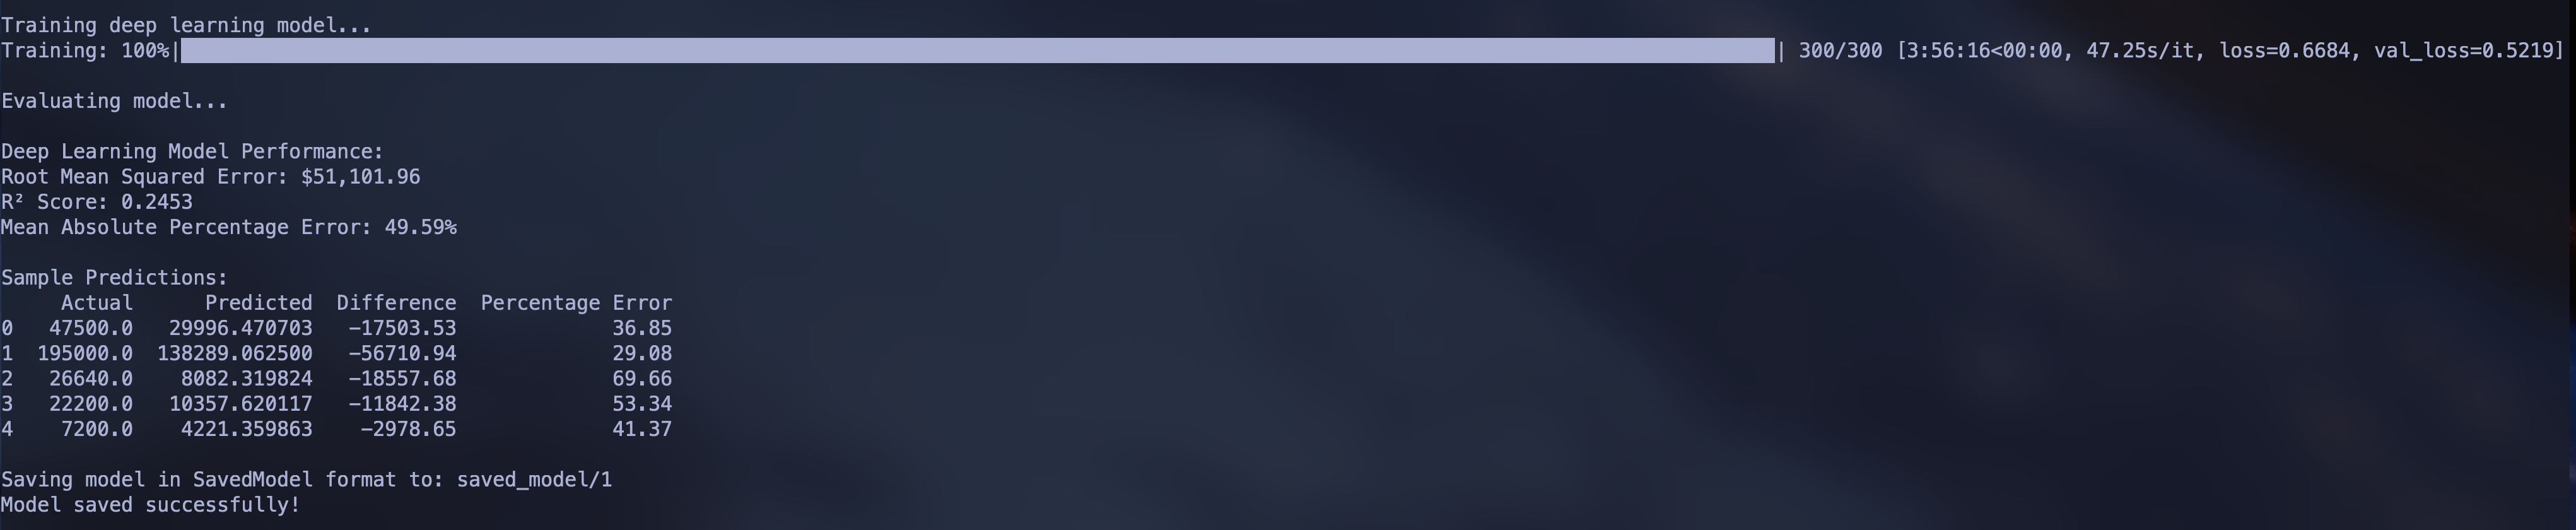

After training for almost 4 hours, the deep learning model did worse than the random forest regressor.

```txt
Training deep learning model...
Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [3:56:16<00:00, 47.25s/it, loss=0.6684, val_loss=0.5219]

Evaluating model...

Deep Learning Model Performance:
Root Mean Squared Error: $51,101.96
R² Score: 0.2453
Mean Absolute Percentage Error: 49.59%

Sample Predictions:
     Actual      Predicted  Difference  Percentage Error
0   47500.0   29996.470703   -17503.53             36.85
1  195000.0  138289.062500   -56710.94             29.08
2   26640.0    8082.319824   -18557.68             69.66
3   22200.0   10357.620117   -11842.38             53.34
4    7200.0    4221.359863    -2978.65             41.37

Saving model in SavedModel format to: saved_model/1
Model saved successfully!
```

# Deep learning with Word2Vec

In [21]:
import pandas as pd
import numpy as np
from gensim.models import Word2Vec
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense,
    Dropout,
)
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import joblib
from tqdm import tqdm
from sklearn.metrics import mean_squared_error, r2_score

# Constants
INPUT_FILE = "../3eda/cleaned_jobs.csv"
WORD2VEC_SIZE = 100
RANDOM_STATE = 42
WORD2VEC_OUTPUT = "word2vec_model.bin"
MODEL_PB_DIR = "salary_model_pb"

In [22]:
# Load and prepare data
print("Loading data...")
df = pd.read_csv(INPUT_FILE)


def parse_list_string(s):
    if pd.isna(s):
        return []
    try:
        return [x.strip().strip("'\"") for x in s.strip("[]").split(",") if x.strip()]
    except:
        return []


# Parse skill columns
df["soft_skills"] = df["soft_skills"].apply(parse_list_string)
df["hard_skills"] = df["hard_skills"].apply(parse_list_string)
df["field_of_study"] = df["field_of_study"].apply(parse_list_string)


# Text preprocessing function
def preprocess_text(text):
    if pd.isna(text):
        return []
    # Convert to lowercase and split
    words = str(text).lower().split()
    # Remove very short words and basic punctuation
    words = [w.strip(".,!?()[]{}:;") for w in words if len(w) > 2]
    return words


# Prepare text sequences for Word2Vec
print("Preparing sequences for Word2Vec...")
all_sequences = []
for idx, row in tqdm(df.iterrows(), total=len(df)):
    sequence = []

    # Add skills and fields as tokens
    sequence.extend([f"soft_{skill.lower()}" for skill in row["soft_skills"]])
    sequence.extend([f"hard_{skill.lower()}" for skill in row["hard_skills"]])
    sequence.extend([f"field_{field.lower()}" for field in row["field_of_study"]])

    # Process job description
    desc_words = preprocess_text(row["job_description"])
    sequence.extend([f"desc_{word}" for word in desc_words])

    # Process job title
    title_words = preprocess_text(row["job_title"])
    sequence.extend([f"title_{word}" for word in title_words])

    # Process query
    query_words = preprocess_text(row["query"])
    sequence.extend([f"query_{word}" for word in query_words])

    # Process location
    if pd.notna(row["location"]):
        sequence.append(f"loc_{str(row['location']).lower()}")

    # Add other categorical features
    for col in [
        "country",
        "location_flexibility",
        "contract_type",
        "education_level",
        "seniority",
    ]:
        if pd.notna(row[col]):
            sequence.append(f"{col}_{str(row[col]).lower()}")

    all_sequences.append(sequence)

Loading data...
Preparing sequences for Word2Vec...



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41514/41514 [00:04<00:00, 8601.40it/s]


In [23]:
# Train Word2Vec model with optimized parameters
print("Training Word2Vec model...")
w2v_model = Word2Vec(
    sentences=all_sequences,
    vector_size=WORD2VEC_SIZE,
    window=5,  # Reduced window size
    min_count=5,  # Increased minimum frequency to reduce vocabulary
    workers=8,  # Increased number of workers for faster processing
    sg=1,  # Skip-gram model
    negative=5,  # Reduced negative sampling
    epochs=5,  # Reduced number of epochs
    compute_loss=True,
)

# Save Word2Vec model
w2v_model.save(WORD2VEC_OUTPUT)

# Create feature vectors
print("Creating feature vectors...")


def create_sequence_vector(sequence):
    vectors = [w2v_model.wv[token] for token in sequence if token in w2v_model.wv]
    if not vectors:
        return np.zeros(WORD2VEC_SIZE)
    return np.mean(vectors, axis=0)


X = np.array([create_sequence_vector(seq) for seq in tqdm(all_sequences)])

Training Word2Vec model...
Creating feature vectors...



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41514/41514 [00:13<00:00, 3082.24it/s]


In [24]:
# Add numerical features
numerical_features = ["min_years_experience"]
for feature in numerical_features:
    feature_values = df[feature].values.reshape(-1, 1)
    scaler = StandardScaler()
    scaled_values = scaler.fit_transform(feature_values)
    X = np.hstack((X, scaled_values))

# Prepare target variable
y = np.log1p(df["yearly_salary_midpoint"].values)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)

In [25]:
# Build deep learning model
print("Building deep learning model...")
model = Sequential(
    [
        Dense(1024, activation="relu", input_shape=(X_train.shape[1],)),
        Dropout(0.3),
        Dense(1024, activation="relu"),
        Dropout(0.2),
        Dense(1024, activation="relu"),
        Dropout(0.1),
        Dense(512, activation="relu"),
        Dense(256, activation="relu"),
        Dense(128, activation="relu"),
        Dense(1),
    ]
)

# Compile model
model.compile(optimizer=Adam(learning_rate=0.001), loss="mse", metrics=["mae"])

# Train model
print("Training deep learning model...")
history = model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor="val_loss", patience=5, restore_best_weights=True
        )
    ],
)

# Evaluate model
print("\nEvaluating model...")
test_loss, test_mae = model.evaluate(X_test, y_test)
print(f"Test MAE: {test_mae:.4f}")

# Make predictions and evaluate
print("\nEvaluating model...")
y_pred = model.predict(X_test, verbose=0)

# Transform predictions back to original scale
y_pred_orig = np.expm1(y_pred)
y_test_orig = np.expm1(y_test)

# Calculate comprehensive metrics
mse = mean_squared_error(y_test_orig, y_pred_orig)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_orig, y_pred_orig)
mape = np.mean(np.abs((y_test_orig - y_pred_orig) / y_test_orig)) * 100

print(f"\nDeep Learning Model Performance:")
print(f"Root Mean Squared Error: ${rmse:,.2f}")
print(f"R² Score: {r2:.4f}")
print(f"Mean Absolute Percentage Error: {mape:.2f}%")

# Print training history
print("\nTraining History:")
for metric in history.history.keys():
    print(f"Final {metric}: {history.history[metric][-1]:.4f}")

# Print sample predictions
print("\nSample Predictions:")
n_samples = 5
sample_indices = np.random.choice(len(y_test_orig), n_samples, replace=False)
comparison = pd.DataFrame(
    {
        "Actual": y_test_orig[sample_indices],
        "Predicted": y_pred_orig[sample_indices].flatten(),
    }
)
comparison["Difference"] = comparison["Predicted"] - comparison["Actual"]
comparison["Percentage Error"] = abs(
    (comparison["Predicted"] - comparison["Actual"]) / comparison["Actual"] * 100
)
print(comparison.round(2))

# Save the model in .pb format
print(f"\nSaving model to {MODEL_PB_DIR} in .pb format...")

# Convert the model to a concrete function
full_model = tf.function(lambda x: model(x))
concrete_func = full_model.get_concrete_function(
    tf.TensorSpec([None, X_train.shape[1]], tf.float32)
)

# Save the model in SavedModel format with .pb
tf.saved_model.save(
    model,
    MODEL_PB_DIR,
    signatures={
        "serving_default": tf.function(
            lambda x: {"output": model(x)}
        ).get_concrete_function(
            tf.TensorSpec([None, X_train.shape[1]], tf.float32, name="input")
        )
    },
)

# Save the Word2Vec parameters separately
print("Saving model parameters...")
model_params = {
    "input_shape": X_train.shape[1],
    "word2vec_size": WORD2VEC_SIZE,
    "numerical_features": numerical_features,
    "feature_scaler": scaler,
}
joblib.dump(model_params, "model_params.joblib")

print("Done! Model saved in .pb format")

# Verify the saved model
print("\nVerifying saved model...")
loaded_model = tf.saved_model.load(MODEL_PB_DIR)
print("Model loaded successfully!")

# Test inference with the loaded model
test_data = X_test[:1]
original_prediction = model.predict(test_data)

# Get prediction from loaded model
serving_fn = loaded_model.signatures["serving_default"]
loaded_prediction = serving_fn(tf.constant(test_data, dtype=tf.float32))
prediction_value = loaded_prediction["output"].numpy()

print("\nPrediction test:")
print(f"Original model prediction: {original_prediction[0][0]:.4f}")
print(f"Loaded model prediction:   {prediction_value[0][0]:.4f}")

Building deep learning model...
Training deep learning model...
Epoch 1/50
831/831 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 7.1431 - mae: 1.6790 - val_loss: 3.1312 - val_mae: 1.5510
Epoch 2/50
831/831 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 1.4720 - mae: 0.9640 - val_loss: 1.7218 - val_mae: 1.1055
Epoch 3/50
831/831 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 1.2920 - mae: 0.9035 - val_loss: 1.0812 - val_mae: 0.8556
Epoch 4/50
831/831 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.9795 - mae: 0.7811 - val_loss: 1.0023 - val_mae: 0.8238
Epoch 5/50
831/831 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.8926 - mae: 0.7255 - val_loss: 0.9853 - val_mae: 0.7927
Epoch 6/50
831/831 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.8322 - mae: 0.6869 - val_loss: 0.6946 - val_mae: 0.6139
Epoch 7/50
831/831 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.7866 - mae: 0.6573 - val_loss: 0.6688 - val_mae: 0.5854
Epoch 8/50
831/831 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.7594 - mae: 0.6392 - val_loss: 0.6582 - val_mae:

INFO:tensorflow:Assets written to: salary_model_pb/assets


Saving model parameters...
Done! Model saved in .pb format

Verifying saved model...
Model loaded successfully!
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

Prediction test:
Original model prediction: 10.5807
Loaded model prediction:   10.5807


Despite training for far less time, the deep learning model with Word2Vec embeddings showed substantial improvements in R^2 and RMSE.

# Training separate deep learning models per country

In [26]:
import pandas as pd
import numpy as np
from gensim.models import Word2Vec
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import joblib
from tqdm import tqdm
from sklearn.metrics import mean_squared_error, r2_score
import os

# Constants
INPUT_FILE = "../3eda/cleaned_jobs.csv"
WORD2VEC_SIZE = 100
RANDOM_STATE = 42
COUNTRIES = ["US", "IN", "SG"]

# Create output directories
os.makedirs("country_models", exist_ok=True)

In [33]:
def parse_list_string(s):
    if pd.isna(s):
        return []
    try:
        return [x.strip().strip("'\"") for x in s.strip("[]").split(",") if x.strip()]
    except:
        return []


def preprocess_text(text):
    if pd.isna(text):
        return []
    words = str(text).lower().split()
    words = [w.strip(".,!?()[]{}:;") for w in words if len(w) > 2]
    return words


def create_sequence_vector(sequence, w2v_model):
    vectors = [w2v_model.wv[token] for token in sequence if token in w2v_model.wv]
    if not vectors:
        return np.zeros(WORD2VEC_SIZE)
    return np.mean(vectors, axis=0)


def train_country_model(country_df, country_code):
    print(f"\n=== Training model for {country_code} ===")
    print(f"Dataset size: {len(country_df)} records")

    # Handle salary distribution
    if country_code == "IN":
        # Remove extreme outliers using quantiles
        Q1 = country_df["yearly_salary_midpoint"].quantile(0.05)
        Q3 = country_df["yearly_salary_midpoint"].quantile(0.95)

        print(f"\nBefore cleaning - Records: {len(country_df)}")
        print(
            f"Salary range: {country_df['yearly_salary_midpoint'].min():,.2f} to {country_df['yearly_salary_midpoint'].max():,.2f}"
        )

        # Filter out extreme values
        country_df = country_df[
            (country_df["yearly_salary_midpoint"] >= Q1)
            & (country_df["yearly_salary_midpoint"] <= Q3)
        ]

        print(f"After cleaning - Records: {len(country_df)}")

        print(
            f"Salary range: {country_df['yearly_salary_midpoint'].min():,.2f} to {country_df['yearly_salary_midpoint'].max():,.2f}"
        )

    # Prepare sequences for Word2Vec
    print("Preparing sequences...")
    all_sequences = []
    for idx, row in tqdm(country_df.iterrows(), total=len(country_df)):
        sequence = []

        # Add skills and fields
        sequence.extend([f"soft_{skill.lower()}" for skill in row["soft_skills"]])
        sequence.extend([f"hard_{skill.lower()}" for skill in row["hard_skills"]])
        sequence.extend([f"field_{field.lower()}" for field in row["field_of_study"]])

        # Process text fields
        sequence.extend(
            [f"desc_{word}" for word in preprocess_text(row["job_description"])]
        )
        sequence.extend([f"title_{word}" for word in preprocess_text(row["job_title"])])
        sequence.extend([f"query_{word}" for word in preprocess_text(row["query"])])

        if pd.notna(row["location"]):
            sequence.append(f"loc_{str(row['location']).lower()}")

        # Add categorical features
        for col in [
            "location_flexibility",
            "contract_type",
            "education_level",
            "seniority",
        ]:
            if pd.notna(row[col]):
                sequence.append(f"{col}_{str(row[col]).lower()}")

        all_sequences.append(sequence)

    # Train Word2Vec
    # We cannot utilize the previous Word2Vec model since we're separating the countries.
    # Therefore, we need 3 separate Word2Vec models to generate the feature vectors for
    # the model.
    print("Training Word2Vec...")
    w2v_model = Word2Vec(
        sentences=all_sequences,
        vector_size=WORD2VEC_SIZE,
        window=5,
        min_count=2,
        workers=8,
        sg=1,
        negative=5,
        epochs=5,
    )

    # Create feature vectors
    print("Creating feature vectors...")
    X = np.array(
        [create_sequence_vector(seq, w2v_model) for seq in tqdm(all_sequences)]
    )

    # Add numerical features
    numerical_features = ["min_years_experience"]
    scaler = StandardScaler()
    for feature in numerical_features:
        feature_values = country_df[feature].values.reshape(-1, 1)
        scaled_values = scaler.fit_transform(feature_values)
        X = np.hstack((X, scaled_values))

    # Prepare target with robust scaling for IN
    if country_code == "IN":
        # Double log transform for extreme skewness
        y = np.log1p(np.log1p(country_df["yearly_salary_midpoint"].values))
    else:
        # Regular log transform for other countries
        y = np.log1p(country_df["yearly_salary_midpoint"].values)

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=RANDOM_STATE
    )

    # Build model
    print("Building and training model...")
    model = Sequential(
        [
            Dense(2048, activation="relu", input_shape=(X_train.shape[1],)),
            Dropout(0.3),
            Dense(2048, activation="relu"),
            Dropout(0.2),
            Dense(1048, activation="relu"),
            Dropout(0.1),
            Dense(512, activation="relu"),
            Dense(256, activation="relu"),
            Dense(128, activation="relu"),
            Dense(1),
        ]
    )

    model.compile(optimizer=Adam(learning_rate=0.001), loss="mse")

    # Train
    history = model.fit(
        X_train,
        y_train,
        validation_split=0.2,
        epochs=50,
        batch_size=32,
        callbacks=[
            tf.keras.callbacks.EarlyStopping(
                monitor="val_loss", patience=5, restore_best_weights=True
            )
        ],
        verbose=1,
    )

    # Evaluate
    print("\nEvaluating model...")
    y_pred = model.predict(X_test, verbose=0)

    # Transform predictions back
    if country_code == "IN":
        # Reverse double log transform for IN
        y_pred_orig = np.expm1(np.expm1(y_pred))
        y_test_orig = np.expm1(np.expm1(y_test))
    else:
        # Regular inverse transform for other countries
        y_pred_orig = np.expm1(y_pred)
        y_test_orig = np.expm1(y_test)

    # Create train/test indices that match our split
    indices = np.arange(len(country_df))
    train_indices, test_indices = train_test_split(
        indices, test_size=0.2, random_state=RANDOM_STATE
    )

    # Calculate metrics
    mse = mean_squared_error(y_test_orig, y_pred_orig)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test_orig, y_pred_orig)
    mape = np.mean(np.abs((y_test_orig - y_pred_orig) / y_test_orig)) * 100

    print(f"\nModel Performance for {country_code}:")
    print(f"Root Mean Squared Error: ${rmse:,.2f}")
    print(f"R² Score: {r2:.4f}")
    print(f"Mean Absolute Percentage Error: {mape:.2f}%")

    # Save models
    model_dir = f"country_models/{country_code}"
    os.makedirs(model_dir, exist_ok=True)

    w2v_model.save(f"{model_dir}/word2vec_model.bin")
    model.export(f"{model_dir}/deep_model")
    joblib.dump(scaler, f"{model_dir}/scaler.joblib")

    # Create predictions DataFrame using the correct test indices
    test_df = country_df.iloc[test_indices].copy()
    test_df = test_df.reset_index(drop=True)
    test_df["predicted_salary"] = y_pred_orig
    test_df["actual_salary"] = test_df["yearly_salary_midpoint"]  # Use original values
    test_df["prediction_error"] = test_df["predicted_salary"] - test_df["actual_salary"]
    test_df["prediction_error_percent"] = (
        test_df["prediction_error"] / test_df["actual_salary"]
    ) * 100

    # Take random subset of 100 predictions (or less if test set is smaller)
    sample_size = min(100, len(test_df))
    sample_df = test_df.sample(n=sample_size, random_state=RANDOM_STATE)

    # Save predictions to CSV
    sample_df.to_csv(f"{model_dir}/test_predictions_sample.csv", index=False)
    print(
        f"\nSaved {sample_size} sample predictions to {model_dir}/test_predictions_sample.csv"
    )

    return {"rmse": rmse, "r2": r2, "mape": mape, "n_samples": len(country_df)}

In [34]:
# Main execution
print("Loading data...")
df = pd.read_csv(INPUT_FILE)

# Parse list columns
df["soft_skills"] = df["soft_skills"].apply(parse_list_string)
df["hard_skills"] = df["hard_skills"].apply(parse_list_string)
df["field_of_study"] = df["field_of_study"].apply(parse_list_string)

# Train separate models for each country
results = {}
for country in COUNTRIES:
    country_df = df[df["country"] == country].copy()
    if len(country_df) > 0:
        results[country] = train_country_model(country_df, country)

# Print comparative results
print("\n=== Comparative Results ===")
results_df = pd.DataFrame(results).T
results_df.columns = ["RMSE", "R²", "MAPE", "Sample Size"]
print(results_df)

# Save results
results_df.to_csv("country_models/comparative_results.csv")
print("\nDone! Models and results saved in 'country_models' directory")

Loading data...

=== Training model for US ===
Dataset size: 18949 records
Preparing sequences...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18949/18949 [00:03<00:00, 4944.10it/s]


Training Word2Vec...
Creating feature vectors...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18949/18949 [00:08<00:00, 2188.81it/s]


Building and training model...
Epoch 1/50
379/379 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - loss: 8.1920 - val_loss: 0.1693
Epoch 2/50
379/379 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.4818 - val_loss: 0.4780
Epoch 3/50
379/379 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.5541 - val_loss: 0.1575
Epoch 4/50
379/379 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.4454 - val_loss: 0.3738
Epoch 5/50
379/379 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.4769 - val_loss: 0.3259
Epoch 6/50
379/379 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.4908 - val_loss: 0.2090
Epoch 7/50
379/379 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 0.4403 - val_loss: 0.1440
Epoch 8/50
379/379 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - loss: 0.4074 - val_loss: 0.2830
Epoch 9/50
379/379 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - loss: 0.4312 - val_loss: 0.1411
Epoch 10/50
379/379 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - loss: 0.3848 - val_loss: 0.1369
Epoch 11/50
379/379 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 0.3454 - val_loss: 0.1386
Epoch 12/5

INFO:tensorflow:Assets written to: country_models/US/deep_model/assets


Saved artifact at 'country_models/US/deep_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 101), dtype=tf.float32, name='keras_tensor_300')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  20615834080: TensorSpec(shape=(), dtype=tf.resource, name=None)
  20615833904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  20613878000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  20613881520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  20602347936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  20613880816: TensorSpec(shape=(), dtype=tf.resource, name=None)
  20613846640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  20601772336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  20601772160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  20601772688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  20615717984: TensorSpec(shape=(), dtype=tf.res

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12878/12878 [00:01<00:00, 9845.60it/s]


Training Word2Vec...
Creating feature vectors...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12878/12878 [00:03<00:00, 3734.84it/s]


Building and training model...
Epoch 1/50
258/258 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 0.2884 - val_loss: 0.0068
Epoch 2/50
258/258 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.0157 - val_loss: 0.0166
Epoch 3/50
258/258 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.0125 - val_loss: 0.0123
Epoch 4/50
258/258 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.0103 - val_loss: 0.0072
Epoch 5/50
258/258 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.0085 - val_loss: 0.0026
Epoch 6/50
258/258 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.0046 - val_loss: 0.0041
Epoch 7/50
258/258 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.0027 - val_loss: 0.0023
Epoch 8/50
258/258 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.0022 - val_loss: 0.0015
Epoch 9/50
258/258 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.0020 - val_loss: 0.0015
Epoch 10/50
258/258 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.0019 - val_loss: 0.0015
Epoch 11/50
258/258 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.0019 - val_loss: 0.0016
Epoch 12/5

INFO:tensorflow:Assets written to: country_models/IN/deep_model/assets


Saved artifact at 'country_models/IN/deep_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 101), dtype=tf.float32, name='keras_tensor_311')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  20609026352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  22634877872: TensorSpec(shape=(), dtype=tf.resource, name=None)
  21682381744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  21682384032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  21682382624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  21754953040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  21754951104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  20862562144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  21682783856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  20604711152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  21761363632: TensorSpec(shape=(), dtype=tf.res

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8306/8306 [00:00<00:00, 11889.07it/s]


Training Word2Vec...
Creating feature vectors...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8306/8306 [00:01<00:00, 4256.03it/s]


Building and training model...
Epoch 1/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 10.5645 - val_loss: 0.2842
Epoch 2/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.5724 - val_loss: 0.3228
Epoch 3/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.5895 - val_loss: 0.5448
Epoch 4/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.6946 - val_loss: 0.3841
Epoch 5/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.5513 - val_loss: 0.5709
Epoch 6/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.6836 - val_loss: 0.7510

Evaluating model...

Model Performance for SG:
Root Mean Squared Error: $30,802.72
R² Score: 0.3252
Mean Absolute Percentage Error: 78.58%
INFO:tensorflow:Assets written to: country_models/SG/deep_model/assets


INFO:tensorflow:Assets written to: country_models/SG/deep_model/assets


Saved artifact at 'country_models/SG/deep_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 101), dtype=tf.float32, name='keras_tensor_322')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  21761360464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  21761362928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  20917597280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  20917615600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  17556032848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  20917614368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  20915588080: TensorSpec(shape=(), dtype=tf.resource, name=None)
  20915585792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  20881145520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  20916730160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  20883189600: TensorSpec(shape=(), dtype=tf.res

**Two Approaches:**
    1.  **Single Global Model:** Train one model using data from all countries.
    2.  **Separate Country Models:** Train three different models, one for each country.

**Analysis of Results (Without Word2Vec):**

**Single Model (Initial):**
RMSE: $51,101.96

R²: 0.2453

MAPE: 49.59%

This model isn't performing very well; it explains only about 25% of the variance, and there are large errors (both absolute and relative) in prediction of salary.

**Single Model (After):**
RMSE: $38,906.74

R²: 0.5309

MAPE: 387.81%

This model shows better prediction capability in terms of explaining the variance, however, the Mean absolute Percentage error is unacceptable.

**Separate Models (With Word2Vec):**

**US:** RMSE: $50,495.06, R²: 0.1969, MAPE: 54.08%

**IN:** RMSE: $2,626.25, R²: 0.2687, MAPE: 46.97%

**SG:** RMSE: $30,944.01, R²: 0.3190, MAPE: 80.23%
    
**Single Model limitations:** The initial single models had very poor performance suggesting it is unable to capture the variance across different countries.

**Recommendation:**

Based on these observations, I recommend the following:

**Train Separate Country Models with Improvements**

**Rationale:**  The separate models demonstrate that each country needs a tailored approach due to its unique salary patterns. This is far superior to the single global model.

**Why Separate Models are Likely Better:**

*   **Flexibility:** Captures nuances specific to each country.
*   **Performance:** Empirically gives better performance compared to global model.

**Why a Single Global Model is Not Recommended:**

*   **Homogenization:** It forces a single relationship between features and salary, ignoring the distinct patterns in each country.
*   **Poorer Performance:** The global model gave the worst performance, suggesting it is not capturing the variance across the countries.



In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Input, Concatenate
from tensorflow.keras.layers import (
    TextVectorization,
    StringLookup,
    CategoryEncoding,
    Normalization,
)
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
import joblib
from tqdm import tqdm
from sklearn.metrics import mean_squared_error, r2_score
import os

# Constants
INPUT_FILE = "../3eda/cleaned_jobs.csv"
RANDOM_STATE = 42
COUNTRIES = ["US", "IN", "SG"]
VOCAB_SIZE = 20000

# Create output directories
os.makedirs("country_models_keras_mlb", exist_ok=True)


def parse_list_string(s):
    if pd.isna(s):
        return []  # Return empty list for NaN
    try:
        return [x.strip().strip("'\"") for x in s.strip("[]").split(",") if x.strip()]
    except:
        return []


def preprocess_text(text):
    if pd.isna(text):
        return ""
    text = str(text).lower()
    text = tf.strings.regex_replace(text, "[.,!?()[]{}:;]", "")
    return text.numpy().decode("utf-8")

In [2]:
def train_country_model(
    country_df,
    country_code,
    text_vectorizers,
    string_lookups,
    normalizer,
    mlb_field_of_study,
):
    print(f"\n=== Training model for {country_code} ===")
    print(f"Dataset size: {len(country_df)} records")

    # # Handle salary distribution
    # if country_code == "IN":
    #     Q1 = country_df["yearly_salary_midpoint"].quantile(0.05)
    #     Q3 = country_df["yearly_salary_midpoint"].quantile(0.95)
    #     country_df = country_df[
    #         (country_df["yearly_salary_midpoint"] >= Q1)
    #         & (country_df["yearly_salary_midpoint"] <= Q3)
    #     ]

    # Prepare features
    print("Preparing features...")

    desc_input = Input(shape=(1,), dtype=tf.string, name="job_description_input")
    title_input = Input(shape=(1,), dtype=tf.string, name="job_title_input")
    query_input = Input(shape=(1,), dtype=tf.string, name="query_input")
    soft_skills_input = Input(shape=(1,), dtype=tf.string, name="soft_skills_input")
    hard_skills_input = Input(shape=(1,), dtype=tf.string, name="hard_skills_input")
    location_flexibility_input = Input(
        shape=(1,), dtype=tf.string, name="location_flexibility_input"
    )
    contract_type_input = Input(shape=(1,), dtype=tf.string, name="contract_type_input")
    education_level_input = Input(
        shape=(1,), dtype=tf.string, name="education_level_input"
    )
    seniority_input = Input(shape=(1,), dtype=tf.string, name="seniority_input")
    min_years_experience_input = Input(
        shape=(1,), dtype=tf.float32, name="min_years_experience_input"
    )

    # StringLookup for field_of_study
    field_of_study_input = Input(
        shape=(1,), dtype=tf.string, name="field_of_study_input"
    )
    field_of_study_index = string_lookups["field_of_study"](
        field_of_study_input
    )  # Get indices from StringLookup
    field_of_study_encoded = CategoryEncoding(
        num_tokens=string_lookups["field_of_study"].vocabulary_size(),
        output_mode="binary",
    )(field_of_study_index)  # Encode indices

    desc_vector = text_vectorizers["job_description"](desc_input)
    title_vector = text_vectorizers["job_title"](title_input)
    query_vector = text_vectorizers["query"](query_input)
    soft_skills_vector = text_vectorizers["soft_skills"](soft_skills_input)
    hard_skills_vector = text_vectorizers["hard_skills"](hard_skills_input)
    location_flexibility_index = string_lookups["location_flexibility"](
        location_flexibility_input
    )  # Get indices
    location_flexibility_encoded = CategoryEncoding(
        num_tokens=string_lookups["location_flexibility"].vocabulary_size(),
        output_mode="binary",
    )(location_flexibility_index)  # Encode indices
    contract_type_index = string_lookups["contract_type"](
        contract_type_input
    )  # Get indices
    contract_type_encoded = CategoryEncoding(
        num_tokens=string_lookups["contract_type"].vocabulary_size(),
        output_mode="binary",
    )(contract_type_index)  # Encode indices
    education_level_index = string_lookups["education_level"](
        education_level_input
    )  # Get indices
    education_level_encoded = CategoryEncoding(
        num_tokens=string_lookups["education_level"].vocabulary_size(),
        output_mode="binary",
    )(education_level_index)  # Encode indices
    seniority_index = string_lookups["seniority"](seniority_input)  # Get indices
    seniority_encoded = CategoryEncoding(
        num_tokens=string_lookups["seniority"].vocabulary_size(), output_mode="binary"
    )(seniority_index)  # Encode indices

    min_years_experience_normalized = normalizer(min_years_experience_input)

    # Concatenate all inputs
    merged_features = Concatenate()(
        [
            desc_vector,
            title_vector,
            query_vector,
            soft_skills_vector,
            hard_skills_vector,
            location_flexibility_encoded,
            contract_type_encoded,
            education_level_encoded,
            seniority_encoded,
            min_years_experience_normalized,
            field_of_study_encoded,
        ]
    )

    dense_layer = Dense(128, activation="relu")(merged_features)
    dropout_layer_1 = Dropout(0.3)(dense_layer)
    dense_layer_2 = Dense(128, activation="relu")(dropout_layer_1)
    dropout_layer_2 = Dropout(0.2)(dense_layer_2)
    dense_layer_3 = Dense(128, activation="relu")(dropout_layer_2)
    dropout_layer_3 = Dropout(0.1)(dense_layer_3)
    dense_layer_4 = Dense(128, activation="relu")(dense_layer_3)
    dense_layer_5 = Dense(64, activation="relu")(dense_layer_4)
    output_layer = Dense(1)(dense_layer_5)

    model = Model(
        inputs={
            "job_description_input": desc_input,
            "job_title_input": title_input,
            "query_input": query_input,
            "soft_skills_input": soft_skills_input,
            "hard_skills_input": hard_skills_input,
            "location_flexibility_input": location_flexibility_input,
            "contract_type_input": contract_type_input,
            "education_level_input": education_level_input,
            "seniority_input": seniority_input,
            "min_years_experience_input": min_years_experience_input,
            "field_of_study_input": field_of_study_input,
        },
        outputs=output_layer,
    )

    model.compile(optimizer=Adam(learning_rate=0.001), loss="mse")

    # Prepare dataset for model training
    def prepare_tf_dataset(df):
        inputs = {}

        # Process text inputs
        inputs["job_description_input"] = tf.convert_to_tensor(
            df["job_description"].fillna("").astype(str).values.reshape(-1, 1),
            dtype=tf.string,
        )
        inputs["job_title_input"] = tf.convert_to_tensor(
            df["job_title"].fillna("").astype(str).values.reshape(-1, 1),
            dtype=tf.string,
        )
        inputs["query_input"] = tf.convert_to_tensor(
            df["query"].fillna("").astype(str).values.reshape(-1, 1), dtype=tf.string
        )

        # Process skills inputs
        inputs["soft_skills_input"] = tf.convert_to_tensor(
            df["soft_skills"]
            .apply(lambda x: " ".join(x) if x else "")
            .values.reshape(-1, 1),
            dtype=tf.string,
        )
        inputs["hard_skills_input"] = tf.convert_to_tensor(
            df["hard_skills"]
            .apply(lambda x: " ".join(x) if x else "")
            .values.reshape(-1, 1),
            dtype=tf.string,
        )

        # Process categorical inputs
        inputs["location_flexibility_input"] = tf.convert_to_tensor(
            df["location_flexibility"]
            .fillna("unknown")
            .astype(str)
            .values.reshape(-1, 1),
            dtype=tf.string,
        )
        inputs["contract_type_input"] = tf.convert_to_tensor(
            df["contract_type"].fillna("unknown").astype(str).values.reshape(-1, 1),
            dtype=tf.string,
        )
        inputs["education_level_input"] = tf.convert_to_tensor(
            df["education_level"].fillna("unknown").astype(str).values.reshape(-1, 1),
            dtype=tf.string,
        )
        inputs["seniority_input"] = tf.convert_to_tensor(
            df["seniority"].fillna("unknown").astype(str).values.reshape(-1, 1),
            dtype=tf.string,
        )

        # Process numerical input
        inputs["min_years_experience_input"] = tf.convert_to_tensor(
            df["min_years_experience"].fillna(0).astype(float).values.reshape(-1, 1),
            dtype=tf.float32,
        )

        # Process field of study input
        field_of_study_str = (
            df["field_of_study"].apply(lambda x: " ".join(x) if x else "unknown").values
        )
        inputs["field_of_study_input"] = tf.convert_to_tensor(
            field_of_study_str.reshape(-1, 1), dtype=tf.string
        )

        # Process target variable
        if country_code == "IN":
            y = np.log1p(np.log1p(df["yearly_salary_midpoint"].values))
        else:
            y = np.log1p(df["yearly_salary_midpoint"].values)

        return inputs, y

    train_df, test_df = train_test_split(
        country_df, test_size=0.2, random_state=RANDOM_STATE
    )
    train_data, y_train = prepare_tf_dataset(train_df)
    test_data, y_test = prepare_tf_dataset(test_df)

    # Train
    print("Building and training model...")
    history = model.fit(
        train_data,
        y_train,
        validation_split=0.2,
        epochs=50,
        batch_size=32,
        callbacks=[
            tf.keras.callbacks.EarlyStopping(
                monitor="val_loss", patience=5, restore_best_weights=True
            )
        ],
        verbose=1,
    )

    # Evaluate
    print("\nEvaluating model...")
    y_pred = model.predict(test_data, verbose=0)

    # Transform predictions back
    if country_code == "IN":
        y_pred_orig = np.expm1(np.expm1(y_pred))
        y_test_orig = np.expm1(np.expm1(y_test))
    else:
        y_pred_orig = np.expm1(y_pred)
        y_test_orig = np.expm1(y_test)

    # Create predictions DataFrame
    test_df_copy = test_df.copy()
    test_df_copy["predicted_salary"] = y_pred_orig.flatten()
    test_df_copy["actual_salary"] = y_test_orig
    test_df_copy["prediction_error"] = (
        test_df_copy["predicted_salary"] - test_df_copy["actual_salary"]
    )
    test_df_copy["prediction_error_percent"] = (
        test_df_copy["prediction_error"] / test_df_copy["actual_salary"]
    ) * 100

    sample_size = min(100, len(test_df_copy))
    sample_df = test_df_copy.sample(n=sample_size, random_state=RANDOM_STATE)

    model_dir = f"country_models_keras_mlb/{country_code}"
    os.makedirs(model_dir, exist_ok=True)
    sample_df.to_csv(f"{model_dir}/test_predictions_sample.csv", index=False)
    print(
        f"\nSaved {sample_size} sample predictions to {model_dir}/test_predictions_sample.csv"
    )

    mse = mean_squared_error(y_test_orig, y_pred_orig)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test_orig, y_pred_orig)
    mape = np.mean(np.abs((y_test_orig - y_pred_orig) / y_test_orig)) * 100

    print(f"\nModel Performance for {country_code}:")
    print(f"Root Mean Squared Error: ${rmse:,.2f}")
    print(f"R² Score: {r2:.4f}")
    print(f"Mean Absolute Percentage Error: {mape:.2f}%")

    input_signature = {
        "job_description_input": tf.TensorSpec(shape=(None, 1), dtype=tf.string, name="job_description_input"),
        "job_title_input": tf.TensorSpec(shape=(None, 1), dtype=tf.string, name="job_title_input"),
        "query_input": tf.TensorSpec(shape=(None, 1), dtype=tf.string, name="query_input"),
        "soft_skills_input": tf.TensorSpec(shape=(None, 1), dtype=tf.string, name="soft_skills_input"),
        "hard_skills_input": tf.TensorSpec(shape=(None, 1), dtype=tf.string, name="hard_skills_input"),
        "location_flexibility_input": tf.TensorSpec(shape=(None, 1), dtype=tf.string, name="location_flexibility_input"),
        "contract_type_input": tf.TensorSpec(shape=(None, 1), dtype=tf.string, name="contract_type_input"),
        "education_level_input": tf.TensorSpec(shape=(None, 1), dtype=tf.string, name="education_level_input"),
        "seniority_input": tf.TensorSpec(shape=(None, 1), dtype=tf.string, name="seniority_input"),
        "min_years_experience_input": tf.TensorSpec(shape=(None, 1), dtype=tf.float32, name="min_years_experience_input"),
        "field_of_study_input": tf.TensorSpec(shape=(None, 1), dtype=tf.string, name="field_of_study_input")
    }
        # Save models
    @tf.function(input_signature=[input_signature])
    def serving_fn(inputs):
        return model(inputs)
        
    tf.saved_model.save(
        model,
        f"{model_dir}/saved_model",
        signatures={
            "serving_default": serving_fn
        }
    )

    return {"rmse": rmse, "r2": r2, "mape": mape, "n_samples": len(country_df)}

In [3]:
# Main execution
print("Loading data...")
df = pd.read_csv(INPUT_FILE)

# Parse list columns
df["soft_skills"] = df["soft_skills"].apply(parse_list_string)
df["hard_skills"] = df["hard_skills"].apply(parse_list_string)
df["field_of_study"] = df["field_of_study"].apply(parse_list_string)

# --- Check point: Print sample of field_of_study after parsing ---
print("\nSample of df['field_of_study'] after parse_list_string:")
print(df["field_of_study"].head())
print("\nAre there still NaN values in df['field_of_study']?:")
print(df["field_of_study"].isnull().any())
# --- End check point ---


# Prepare TextVectorization layers
print("Preparing Text Vectorization layers...")
text_feature_names = ["job_description", "job_title", "query"]
text_vectorizers = {}

# For regular text features
for feature_name in text_feature_names:
    text_vectorizer = TextVectorization(max_tokens=VOCAB_SIZE, output_mode="binary")
    text_vectorizer.adapt(df[feature_name].fillna("").astype(str).values)
    text_vectorizers[feature_name] = text_vectorizer

# For skills features
# Convert skills lists to space-separated strings
df["soft_skills_str"] = df["soft_skills"].apply(lambda x: " ".join(x) if x else "")
df["hard_skills_str"] = df["hard_skills"].apply(lambda x: " ".join(x) if x else "")

# Create and adapt vectorizers for skills
text_vectorizers["soft_skills"] = TextVectorization(
    max_tokens=VOCAB_SIZE // 2,  # Smaller vocabulary for skills
    output_mode="binary",
)
text_vectorizers["soft_skills"].adapt(df["soft_skills_str"].values)

text_vectorizers["hard_skills"] = TextVectorization(
    max_tokens=VOCAB_SIZE // 2,  # Smaller vocabulary for skills
    output_mode="binary",
)
text_vectorizers["hard_skills"].adapt(df["hard_skills_str"].values)


# Prepare StringLookup layers for categorical features
print("Preparing StringLookup layers for categorical features...")
categorical_feature_names = [
    "location_flexibility",
    "contract_type",
    "education_level",
    "seniority",
]
string_lookups = {}
for feature_name in categorical_feature_names:
    unique_categories = sorted(
        list(df[feature_name].dropna().astype(str).str.lower().unique())
    )
    string_lookup = StringLookup(
        vocabulary=["unknown"] + unique_categories, mask_token=None
    )
    string_lookups[feature_name] = (
        string_lookup  # Store StringLookup directly, encoding is done in model
    )


# StringLookup for field_of_study
unique_fields_of_study = set()
for fos_list in df["field_of_study"].dropna():
    unique_fields_of_study.update(fos_list)
unique_fields_of_study = sorted(list(unique_fields_of_study))
string_lookup_fos = StringLookup(
    vocabulary=["unknown"] + unique_fields_of_study, mask_token=None
)
string_lookups["field_of_study"] = (
    string_lookup_fos  # Store StringLookup directly, encoding is done in model
)


# Prepare Normalization layer for numerical features
print("Preparing Normalization layer for numerical features...")
numerical_feature_names = ["min_years_experience"]
normalizer = Normalization(axis=None)

numerical_data = (
    df[numerical_feature_names].fillna(0).astype(float).to_numpy()
)  # Explicitly convert to NumPy array
numerical_data = numerical_data.reshape(-1)  # Reshape to 1D array

print(
    "Shape of numerical data for Normalization:", numerical_data.shape
)  # Shape after reshape
print("Data type of numerical data for Normalization:", numerical_data.dtype)
print(
    "Sample of numerical data for Normalization:\n", numerical_data[:5]
)  # Sample after reshape


normalizer.adapt(numerical_data)


# Train separate models for each country
results = {}
for country in COUNTRIES:
    country_df = df[df["country"] == country].copy()
    if len(country_df) > 0:
        results[country] = train_country_model(
            country_df,
            country,
            text_vectorizers,
            string_lookups,
            normalizer,
            mlb_field_of_study=None,
        )  # MLB is not used directly in model


# Print comparative results
print("\n=== Comparative Results ===")
results_df = pd.DataFrame(results).T
results_df.columns = ["RMSE", "R²", "MAPE", "Sample Size"]
print(results_df)

# Save results
print("\nDone! Models and results saved in 'country_models_keras_mlb' directory")

Loading data...

Sample of df['field_of_study'] after parse_list_string:
0    [engineering, computer-science, software-engin...
1             [computer-science, software-engineering]
2    [computer-science, web-design, software-engine...
3    [computer-science, machine-learning, software-...
4    [computer-science, statistics, mathematics, en...
Name: field_of_study, dtype: object

Are there still NaN values in df['field_of_study']?:
False
Preparing Text Vectorization layers...
Preparing StringLookup layers for categorical features...
Preparing Normalization layer for numerical features...
Shape of numerical data for Normalization: (41514,)
Data type of numerical data for Normalization: float64
Sample of numerical data for Normalization:
 [5. 0. 3. 2. 0.]

=== Training model for US ===
Dataset size: 18949 records
Preparing features...
Building and training model...
Epoch 1/50
379/379 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 18.0219 - val_loss: 13.2366
Epoch 2/50
379/379 ━━━━━━━━━━━━━━

INFO:tensorflow:Assets written to: country_models_keras_mlb/US/saved_model/assets



=== Training model for IN ===
Dataset size: 14259 records
Preparing features...
Building and training model...
Epoch 1/50
286/286 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.5508 - val_loss: 0.1839
Epoch 2/50
286/286 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.0260 - val_loss: 0.0257
Epoch 3/50
286/286 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.0048 - val_loss: 0.0070
Epoch 4/50
286/286 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.0036 - val_loss: 0.0083
Epoch 5/50
286/286 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.0027 - val_loss: 0.0104
Epoch 6/50
286/286 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.0025 - val_loss: 0.0052
Epoch 7/50
286/286 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.0019 - val_loss: 0.0066
Epoch 8/50
286/286 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.0015 - val_loss: 0.0038
Epoch 9/50
286/286 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.0014 - val_loss: 0.0026
Epoch 10/50
286/286 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.0014 - val_loss: 0.0040
Epoch 11/50
286/2

INFO:tensorflow:Assets written to: country_models_keras_mlb/IN/saved_model/assets



=== Training model for SG ===
Dataset size: 8306 records
Preparing features...
Building and training model...
Epoch 1/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 25.4511 - val_loss: 7.4154
Epoch 2/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 1.7550 - val_loss: 8.4163
Epoch 3/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.9615 - val_loss: 6.2171
Epoch 4/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.7607 - val_loss: 6.2765
Epoch 5/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.5911 - val_loss: 8.5527
Epoch 6/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.4369 - val_loss: 4.5922
Epoch 7/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.3001 - val_loss: 2.8560
Epoch 8/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.2227 - val_loss: 2.2959
Epoch 9/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.1520 - val_loss: 3.1860
Epoch 10/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.1818 - val_loss: 1.6009
Epoch 11/50
167/1

INFO:tensorflow:Assets written to: country_models_keras_mlb/SG/saved_model/assets



=== Comparative Results ===
            RMSE        R²       MAPE  Sample Size
US  50494.328260  0.196898  43.114340      18949.0
IN   5418.887863  0.201675  71.228134      14259.0
SG  32827.831505  0.233565  53.373194       8306.0

Done! Models and results saved in 'country_models_keras_mlb' directory


In [4]:
def predict_salary_simple(model_path, 
                         job_description,
                         job_title,
                         query,
                         soft_skills,
                         hard_skills,
                         location_flexibility,
                         contract_type,
                         education_level,
                         seniority,
                         min_years_experience,
                         field_of_study,
                         country_code="US"):
    """
    Simplified prediction function that takes regular Python types
    """
    # Ensure all inputs are properly shaped as 2D tensors
    input_data = {
        "job_description_input": tf.reshape(tf.convert_to_tensor([job_description], dtype=tf.string), (-1, 1)),
        "job_title_input": tf.reshape(tf.convert_to_tensor([job_title], dtype=tf.string), (-1, 1)),
        "query_input": tf.reshape(tf.convert_to_tensor([query], dtype=tf.string), (-1, 1)),
        "soft_skills_input": tf.reshape(tf.convert_to_tensor([" ".join(soft_skills) if isinstance(soft_skills, list) else soft_skills], dtype=tf.string), (-1, 1)),
        "hard_skills_input": tf.reshape(tf.convert_to_tensor([" ".join(hard_skills) if isinstance(hard_skills, list) else hard_skills], dtype=tf.string), (-1, 1)),
        "location_flexibility_input": tf.reshape(tf.convert_to_tensor([location_flexibility], dtype=tf.string), (-1, 1)),
        "contract_type_input": tf.reshape(tf.convert_to_tensor([contract_type], dtype=tf.string), (-1, 1)),
        "education_level_input": tf.reshape(tf.convert_to_tensor([education_level], dtype=tf.string), (-1, 1)),
        "seniority_input": tf.reshape(tf.convert_to_tensor([seniority], dtype=tf.string), (-1, 1)),
        "min_years_experience_input": tf.reshape(tf.convert_to_tensor([float(min_years_experience)], dtype=tf.float32), (-1, 1)),
        "field_of_study_input": tf.reshape(tf.convert_to_tensor([" ".join(field_of_study) if isinstance(field_of_study, list) else field_of_study], dtype=tf.string), (-1, 1))
    }
    
    loaded_model = tf.saved_model.load(model_path)
    predict_fn = loaded_model.signatures["serving_default"]
    prediction = predict_fn(**input_data)
    # Get the output key from the prediction (it might be different depending on how the model was saved)
    output_key = list(prediction.keys())[0]  # Get the first (and should be only) key
    print(f"Available prediction keys: {prediction.keys()}")  # Debug print
    salary_prediction = prediction[output_key].numpy()
    
    if country_code == "IN":
        final_salary = np.expm1(np.expm1(salary_prediction))
    else:
        final_salary = np.expm1(salary_prediction)
    
    return float(final_salary)


# Example usage:
predicted_salary = predict_salary_simple(
    model_path="country_models_keras_mlb/SG/saved_model",
    job_description="Software engineer position...",
    job_title="Software Engineer",
    query="software engineer",
    soft_skills=["communication", "teamwork"],
    hard_skills=["python", "javascript"],
    location_flexibility="remote",
    contract_type="full_time",
    education_level="bachelor",
    seniority="mid",
    min_years_experience=3,
    field_of_study=["computer science"],
    country_code="SG"
)

print(f"Predicted salary: ${predicted_salary:,.2f}")

Available prediction keys: dict_keys(['output_0'])
Predicted salary: $26,783.06


/var/folders/jc/mky5brlx03z7bnn4kgbmdqhm0000gp/T/ipykernel_15790/3625148170.py:45: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(final_salary)
